<h1><center><font size="6">Analysis Template</font></center></h1>

<h2><center><font size="4">Client Subscription Model</font></center></h2>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
 - <a href='#31'>Check the data</a>   
 - <a href='#32'>Density plots of features</a>   
 - <a href='#33'>Distribution of mean and std</a>   
 - <a href='#34'>Distribution of min and max</a>   
  - <a href='#35'>Distribution of skew and kurtosis</a>   
 - <a href='#36'>Features correlations</a>   
 - <a href='#37'>Duplicate values</a>   
- <a href='#4'>Feature engineering</a>
- <a href='#5'>Model</a>
- <a href='#6'>Conclusion</a>

# <a id='1'>Introduction</a>  

The bank data is anonimyzed, each row containing 20 values. Half of them are categorical and the rest numeric. 

In the following we will explore the data, split train and test datasets, prepare it for a model, train a model and predict the target value for the test set. We will then try to identify the 5 most predictive values and we will use them in a new model to compare the benefits.


# <a id='2'>Prepare for data analysis</a>  


## Load packages


In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as plty

from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
warnings.filterwarnings('ignore')

# run external scripts
%run ./plot_funcs.py

## Load data   

Load data and split into test and train.

In [2]:
%%time
df = pd.read_csv('data_set.csv', header=0)
cols = df.columns.to_list()[0].split(sep=';')
df = df[df.columns.to_list()[0]].str.split(';', expand=True)

for i, col in enumerate(cols):
    cols[i] = col.replace('"', '')

df.columns = cols

# set feature types with memory optimisation
data_type = {'age': np.int8, 'duration': np.int16, 'campaign': np.int8,
             'pdays': np.int16, 'previous': np.int8, 'emp.var.rate':
            np.float32, 'cons.price.idx': np.float32, 'cons.conf.idx':
            np.float32, 'euribor3m': np.float32, 'nr.employed': np.float32,
            'y': np.int8}

df['y'].replace(to_replace={'"yes"': 1, '"no"': 0}, inplace=True)
df = df.astype(dtype=data_type, errors='raise')

CPU times: user 1.07 s, sys: 56.6 ms, total: 1.12 s
Wall time: 1.18 s


Split train/test sample and categorical/numerical variables.

In [3]:
%%time
# replace 999 with a negative number -1
df['pdays'] = df['pdays'].where(df['pdays']!=999, -1)

# split train and test set 80-20%
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

categ_feat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week',
              'poutcome']
numer_feat = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
              'cons.conf.idx', 'euribor3m', 'nr.employed']
target = 'y'

CPU times: user 31.6 ms, sys: 8.08 ms, total: 39.7 ms
Wall time: 355 ms


# <a id='3'>Data exploration</a>  

## <a id='31'>Check the data</a>  

Let's check the train and test set.

In [4]:
train_df.shape, test_df.shape

((32950, 21), (8238, 21))

Train and test data have 32,950 and 8,238 entries respectivelly and 21 columns. 

Let's glimpse train and test dataset.

In [5]:
train_df.head()

age             job    marital              education    default  \
24717   32  "entrepreneur"  "married"    "university.degree"       "no"   
8883    31   "blue-collar"   "single"             "basic.4y"       "no"   
20212   35    "technician"  "married"  "professional.course"       "no"   
35708   33    "technician"   "single"          "high.school"       "no"   
9994    59       "retired"  "married"  "professional.course"  "unknown"   

         housing       loan      contact  month day_of_week  ...  campaign  \
24717      "yes"      "yes"  "telephone"  "nov"       "mon"  ...         1   
8883        "no"       "no"  "telephone"  "jun"       "thu"  ...         3   
20212      "yes"       "no"   "cellular"  "aug"       "mon"  ...         1   
35708  "unknown"  "unknown"   "cellular"  "may"       "mon"  ...         2   
9994       "yes"       "no"  "telephone"  "jun"       "wed"  ...         8   

       pdays  previous       poutcome emp.var.rate  cons.price.idx  \
24717     -1         1      "failure"         -0.1       93.199997   
8883      -1         0  "nonexistent"          1.4       94.464996   
20212     -1         0  "nonexistent"          1.4       93.444000   
35708     -1         0  "nonexistent"         -1.8       92.892998   
9994      -1         0  "nonexistent"          1.4       94.464996   

       cons.conf.idx  euribor3m  nr.employed  y  
24717     -42.000000      4.191  5195.799805  0  
8883      -41.799999      4.866  5228.100098  1  
20212     -36.099998      4.965  5228.100098  0  
35708     -46.200001      1.244  5099.100098  0  
9994      -41.799999      4.959  5228.100098  0  

[5 rows x 21 columns]

In [6]:
test_df.head()

age            job     marital            education    default housing  \
12509   59   "technician"  "divorced"  "university.degree"       "no"    "no"   
20064   47       "admin."   "married"  "university.degree"  "unknown"   "yes"   
9309    27  "blue-collar"    "single"           "basic.6y"       "no"   "yes"   
22124   44  "blue-collar"   "married"           "basic.4y"  "unknown"   "yes"   
27955   32       "admin."   "married"  "university.degree"       "no"   "yes"   

        loan      contact  month day_of_week  ...  campaign  pdays  previous  \
12509   "no"   "cellular"  "jul"       "mon"  ...         1     -1         0   
20064   "no"   "cellular"  "aug"       "mon"  ...         1     -1         0   
9309   "yes"  "telephone"  "jun"       "fri"  ...         2     -1         0   
22124   "no"   "cellular"  "aug"       "thu"  ...         1     -1         0   
27955   "no"   "cellular"  "mar"       "mon"  ...         1     -1         0   

            poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
12509  "nonexistent"          1.4       93.917999     -42.700001      4.960   
20064  "nonexistent"          1.4       93.444000     -36.099998      4.965   
9309   "nonexistent"          1.4       94.464996     -41.799999      4.967   
22124  "nonexistent"          1.4       93.444000     -36.099998      4.963   
27955  "nonexistent"         -1.8       92.843002     -50.000000      1.520   

       nr.employed  y  
12509  5228.100098  0  
20064  5228.100098  0  
9309   5228.100098  0  
22124  5228.100098  0  
27955  5099.100098  1  

[5 rows x 21 columns]

Datasets contain:  

* **'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'** (string);  
* **target 'y'** (binary);  
* **'age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'** numerical variables (floats and ints);

Let's check if there is any missing data. We will also chech the type of data (correctly assigned after exploring features' range of values and type).


In [7]:
%%time
missing_data(train_df)

CPU times: user 144 ms, sys: 4.96 ms, total: 149 ms
Wall time: 161 ms


age     job marital education default housing    loan contact  \
Total       0       0       0         0       0       0       0       0   
Percent     0       0       0         0       0       0       0       0   
Types    int8  object  object    object  object  object  object  object   

          month day_of_week  ... campaign  pdays previous poutcome  \
Total         0           0  ...        0      0        0        0   
Percent       0           0  ...        0      0        0        0   
Types    object      object  ...     int8  int16     int8   object   

        emp.var.rate cons.price.idx cons.conf.idx euribor3m nr.employed     y  
Total              0              0             0         0           0     0  
Percent            0              0             0         0           0     0  
Types        float32        float32       float32   float32     float32  int8  

[3 rows x 21 columns]

Here we check test dataset.

In [8]:
%%time
missing_data(test_df)

CPU times: user 54.6 ms, sys: 2.64 ms, total: 57.2 ms
Wall time: 65.2 ms


age     job marital education default housing    loan contact  \
Total       0       0       0         0       0       0       0       0   
Percent     0       0       0         0       0       0       0       0   
Types    int8  object  object    object  object  object  object  object   

          month day_of_week  ... campaign  pdays previous poutcome  \
Total         0           0  ...        0      0        0        0   
Percent       0           0  ...        0      0        0        0   
Types    object      object  ...     int8  int16     int8   object   

        emp.var.rate cons.price.idx cons.conf.idx euribor3m nr.employed     y  
Total              0              0             0         0           0     0  
Percent            0              0             0         0           0     0  
Types        float32        float32       float32   float32     float32  int8  

[3 rows x 21 columns]

There are no missing data in train and test datasets. Let's check the numerical values in train and test dataset.

In [9]:
%%time
train_df.describe()

CPU times: user 141 ms, sys: 11.4 ms, total: 152 ms
Wall time: 207 ms


age      duration      campaign         pdays      previous  \
count  32950.000000  32950.000000  32950.000000  32950.000000  32950.000000   
mean      40.018149    258.569196      2.562549     -0.746100      0.172747   
std       10.423371    259.707642      2.766087      1.488959      0.494368   
min       17.000000      0.000000      1.000000     -1.000000      0.000000   
25%       32.000000    102.000000      1.000000     -1.000000      0.000000   
50%       38.000000    179.000000      2.000000     -1.000000      0.000000   
75%       47.000000    320.000000      3.000000     -1.000000      0.000000   
max       98.000000   4918.000000     56.000000     26.000000      6.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m  \
count  32950.000000    32950.000000   32950.000000  32950.000000   
mean       0.079758       93.592194     -40.525730      3.617758   
std        1.569936        0.578863       4.621397      1.735154   
min       -3.400000       92.200996     -50.799999      0.634000   
25%       -1.800000       93.074997     -42.700001      1.344000   
50%        1.100000       93.749001     -41.799999      4.857000   
75%        1.400000       93.994003     -36.400002      4.961000   
max        1.400000       94.766998     -26.900000      5.045000   

        nr.employed             y  
count  32950.000000  32950.000000  
mean    5167.669922      0.112868  
std       72.337090      0.316436  
min     4963.600098      0.000000  
25%     5099.100098      0.000000  
50%     5191.000000      0.000000  
75%     5228.100098      0.000000  
max     5228.100098      1.000000

In [10]:
%time
test_df.describe()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


age     duration     campaign        pdays     previous  \
count  8238.000000  8238.000000  8238.000000  8238.000000  8238.000000   
mean     40.047706   257.148337     2.587764    -0.725540     0.173829   
std      10.413359   257.571206     2.785741     1.592917     0.497057   
min      17.000000     0.000000     1.000000    -1.000000     0.000000   
25%      32.000000   103.000000     1.000000    -1.000000     0.000000   
50%      38.000000   180.000000     2.000000    -1.000000     0.000000   
75%      47.000000   317.000000     3.000000    -1.000000     0.000000   
max      95.000000  4199.000000    37.000000    27.000000     7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx    euribor3m  nr.employed  \
count   8238.000000     8238.000000    8238.000000  8238.000000  8238.000000   
mean       0.090365       93.575203     -40.411633     3.636024  5167.578613   
std        1.574565        0.579755       4.654423     1.731908    71.904366   
min       -3.400000       92.200996     -50.799999     0.634000  4963.600098   
25%       -1.800000       93.074997     -42.700001     1.344000  5099.100098   
50%        1.100000       93.875999     -41.799999     4.857000  5191.000000   
75%        1.400000       93.994003     -36.400002     4.961000  5228.100098   
max        1.400000       94.766998     -26.900000     5.045000  5228.100098   

                 y  
count  8238.000000  
mean      0.111799  
std       0.315138  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

We can make few observations here:   

* standard deviation is relatively large for both train and test variable data;  
* min, max, mean, std values for train and test data looks quite close;  
* mean values are distributed over a large range.

The number of values in train and test set is the same. Let's plot the scatter plot for train and test set for few of the features.


We will show just 25% of the train data amd all test data. On x axis we show train values and on the y axis we show the test values.

<Figure size 432x288 with 0 Axes>

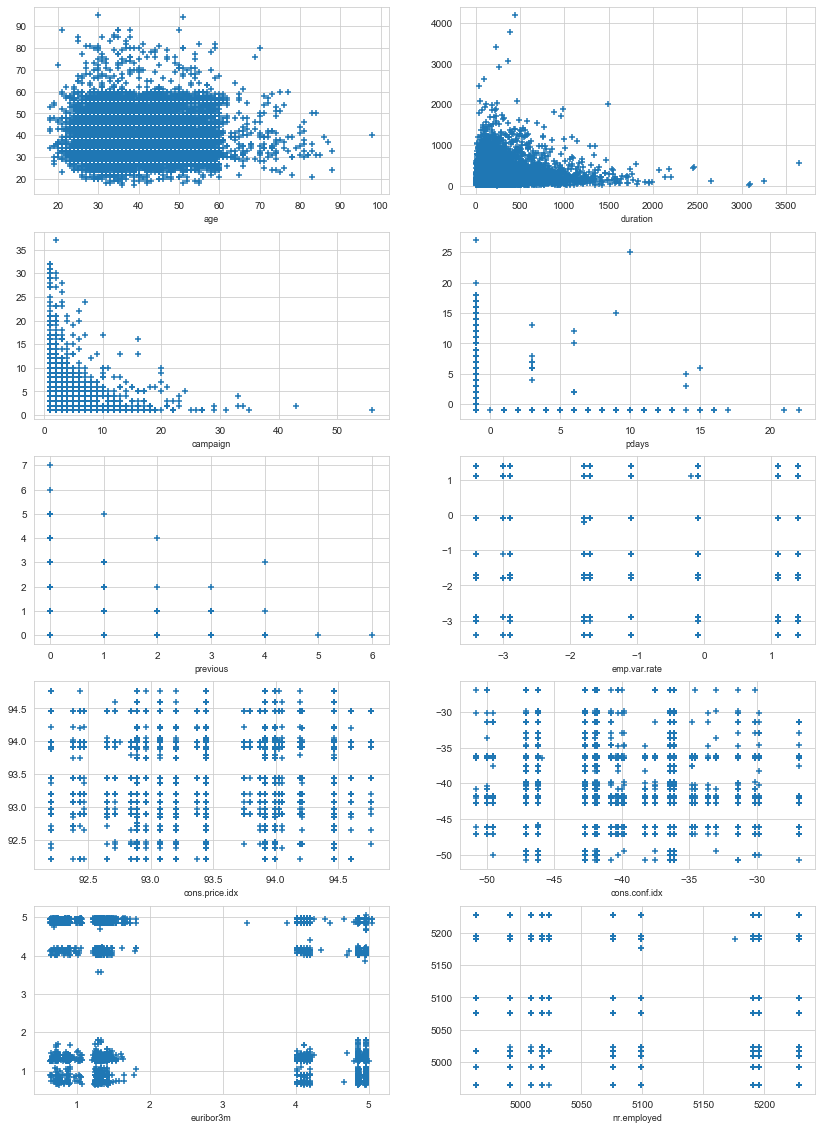

In [11]:
features = numer_feat

plot_feature_scatter(train_df[:len(test_df)], test_df, features)

Let's check the distribution of **target** value in train dataset.

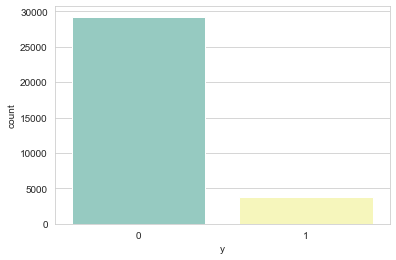

In [12]:
sns.countplot(train_df[target], palette='Set3')

In [13]:
print("There are {0:.3f}% target values with 1".format(100 * train_df[target].value_counts()[1]/train_df.shape[0]))

There are 11.287% target values with 1


Let's check the distribution of **target** value in test dataset.

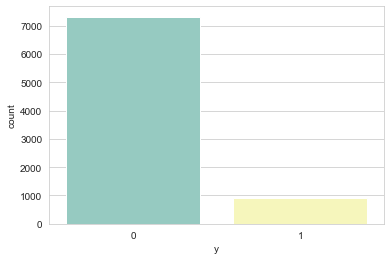

In [14]:
sns.countplot(test_df[target], palette='Set3')

In [15]:
print("There are {0:.2f}% target values with 1".format(100 * test_df[target].value_counts()[1]/test_df.shape[0]))

There are 11.18% target values with 1


Below, we can summarise the distributions and relationship between all numerical features (grouped by class; train set):

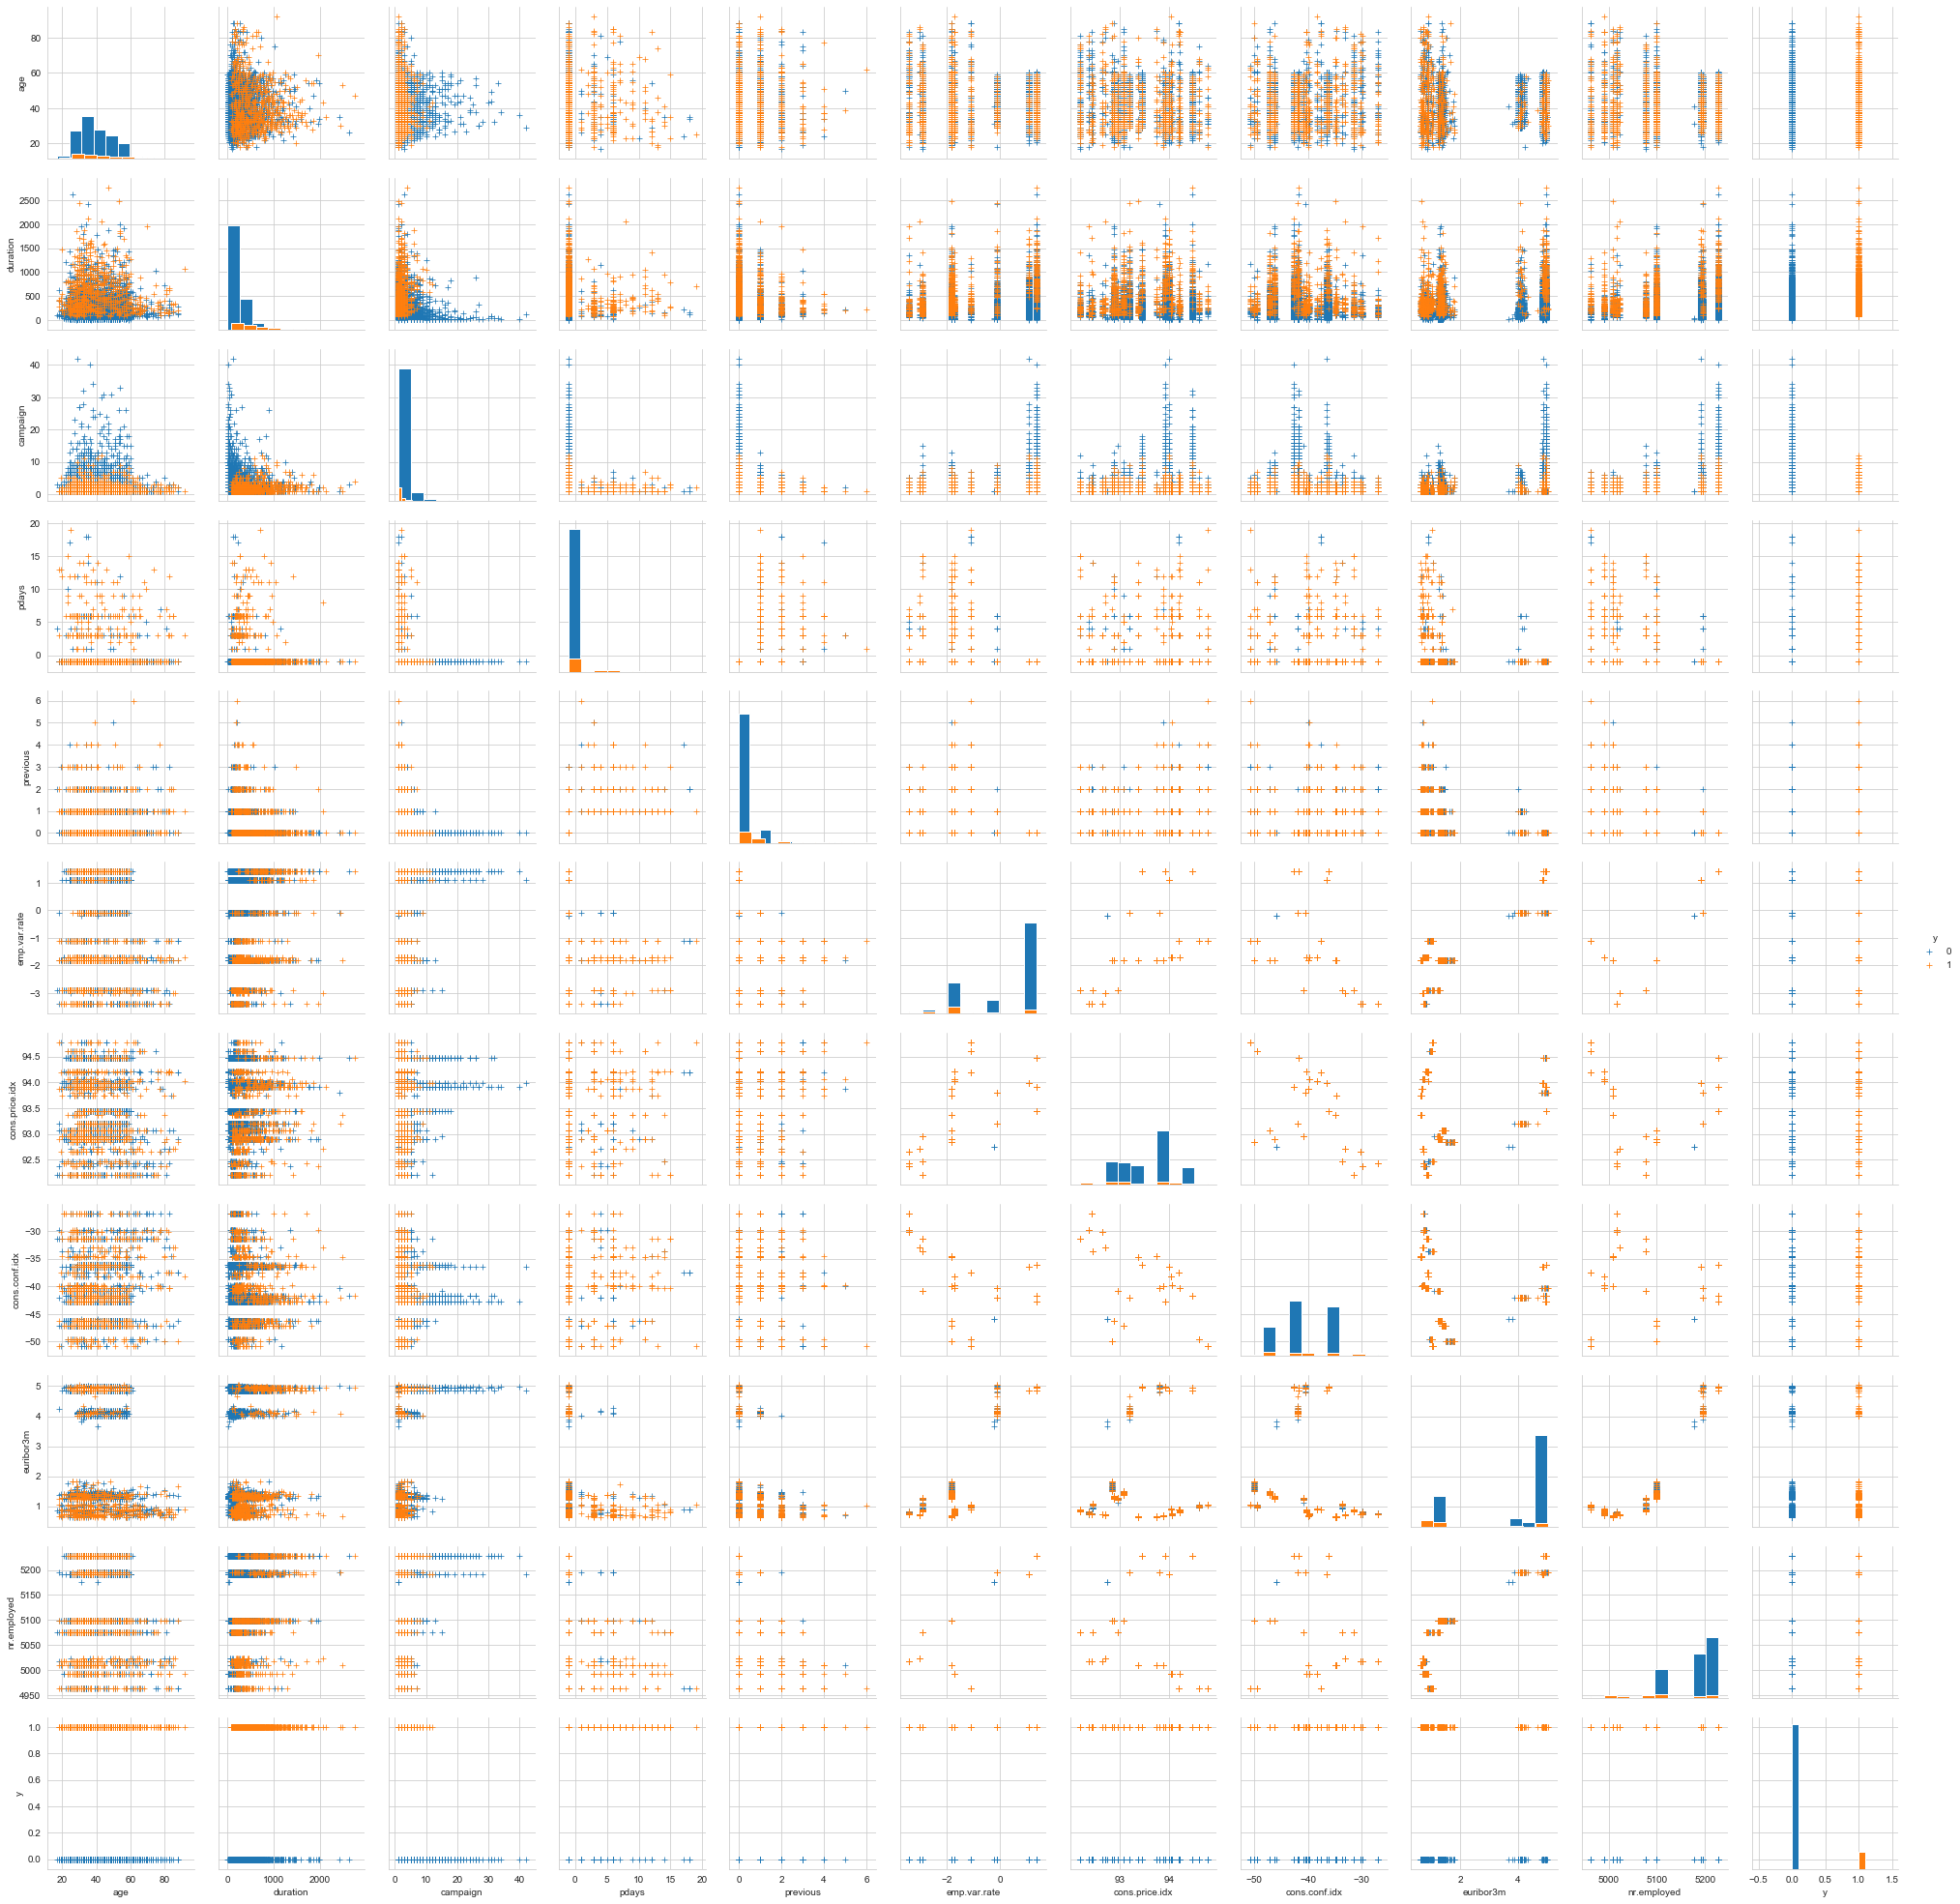

In [16]:
sns.pairplot(train_df[numer_feat+['y']][::5], hue='y', markers='+', kind='scatter', diag_kind='hist')
plt.show()

The data is unbalanced with respect with **target** value. For the shake of speeding up the analysis, we will assume that we did a good job into splitting the train and test sample and they are both representative of the overall sample.

With this in mind, we will dig deeper into the investigation of **categorical** values on the train test.

### Job

In [16]:
train_df['job'].unique()

array(['"blue-collar"', '"admin."', '"retired"', '"technician"',
       '"services"', '"management"', '"entrepreneur"', '"self-employed"',
       '"student"', '"unemployed"', '"unknown"', '"housemaid"'],
      dtype=object)

In [17]:
categ_feat_dfs = []
categ_feat_test_dfs = []

job_cat = pd.get_dummies(train_df['job'], prefix='job', drop_first=False)
job_cat.columns = [col.replace('"', '') for col in job_cat.columns]
job_cat.drop(['job_unknown'], axis=1, inplace=True)

job_cat_test = pd.get_dummies(test_df['job'], prefix='job', drop_first=False)
job_cat_test.columns = [col.replace('"', '') for col in job_cat_test.columns]
job_cat_test.drop(['job_unknown'], axis=1, inplace=True)

categ_feat_test_dfs.append(job_cat_test)
categ_feat_dfs.append(job_cat)

<Figure size 432x288 with 0 Axes>

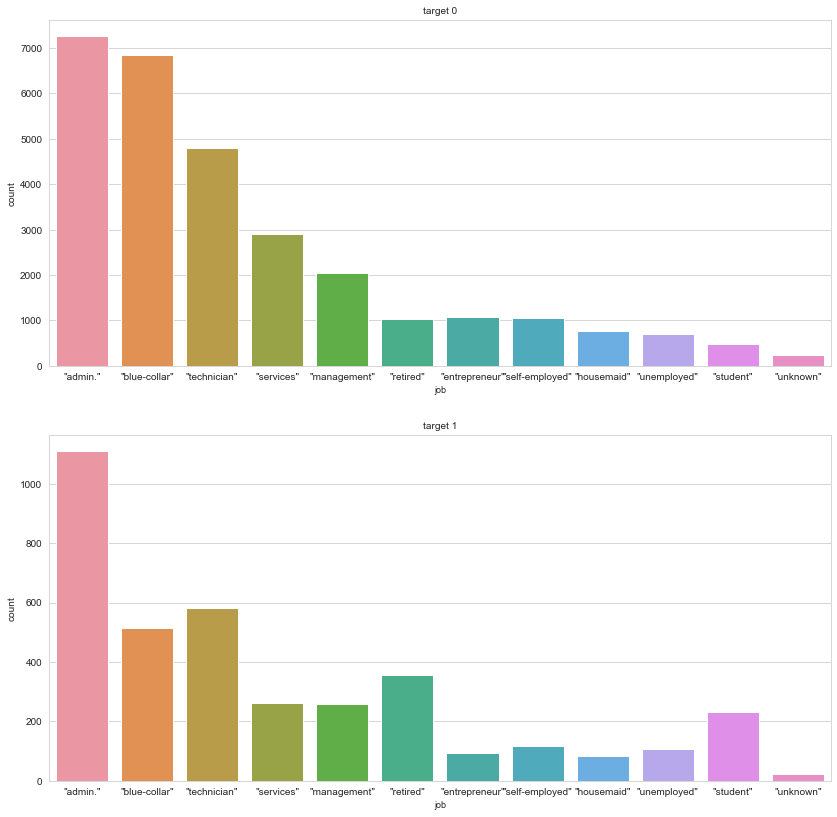

In [18]:
plot_feature_categ(train_df, 'job', target)

### Marital

In [19]:
train_df['marital'].unique()

array(['"married"', '"divorced"', '"single"', '"unknown"'], dtype=object)

In [20]:
marital_cat = pd.get_dummies(train_df['marital'], prefix='marital', drop_first=False)
marital_cat.columns = [col.replace('"', '') for col in marital_cat.columns]
marital_cat.drop(['marital_unknown'], axis=1, inplace=True)

marital_cat_test = pd.get_dummies(test_df['marital'], prefix='marital', drop_first=False)
marital_cat_test.columns = [col.replace('"', '') for col in marital_cat_test.columns]
marital_cat_test.drop(['marital_unknown'], axis=1, inplace=True)

categ_feat_test_dfs.append(marital_cat_test)
categ_feat_dfs.append(marital_cat)

<Figure size 432x288 with 0 Axes>

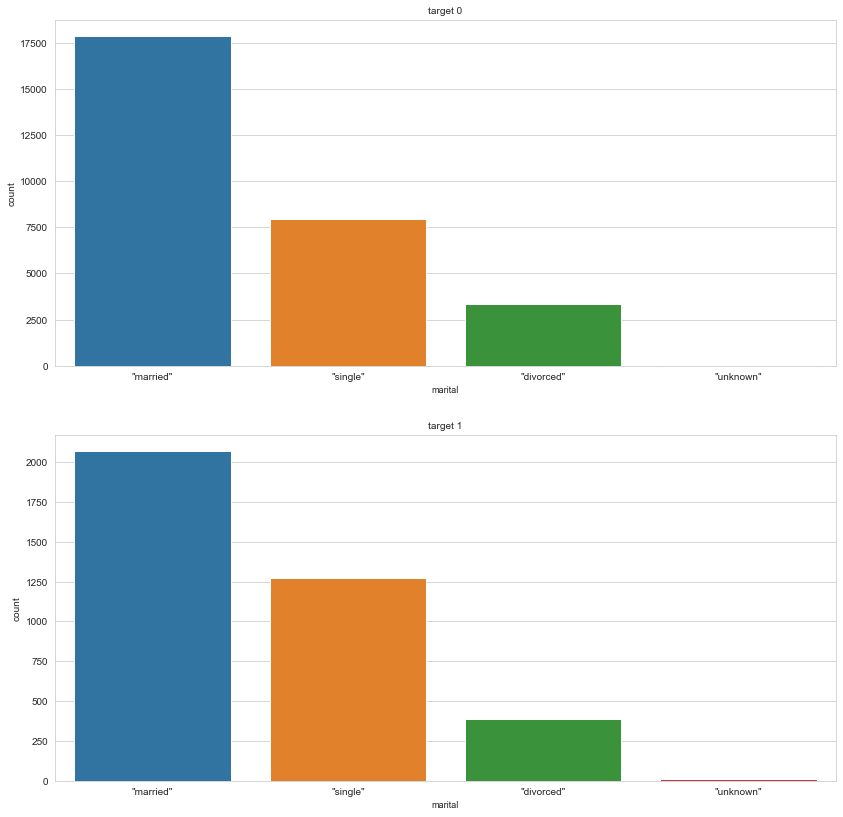

In [21]:
plot_feature_categ(train_df, 'marital', target)

### Education

In [22]:
train_df['education'].unique()

array(['"basic.4y"', '"high.school"', '"professional.course"',
       '"basic.9y"', '"university.degree"', '"basic.6y"', '"unknown"',
       '"illiterate"'], dtype=object)

In [23]:
education_cat = pd.get_dummies(train_df['education'], prefix='education', drop_first=False)
education_cat.columns = [col.replace('"', '') for col in education_cat.columns]
education_cat.drop(['education_unknown'], axis=1, inplace=True)

education_cat_test = pd.get_dummies(test_df['education'], prefix='education', drop_first=False)
education_cat_test.columns = [col.replace('"', '') for col in education_cat_test.columns]
education_cat_test.drop(['education_unknown'], axis=1, inplace=True)

categ_feat_test_dfs.append(education_cat_test)
categ_feat_dfs.append(education_cat)

<Figure size 432x288 with 0 Axes>

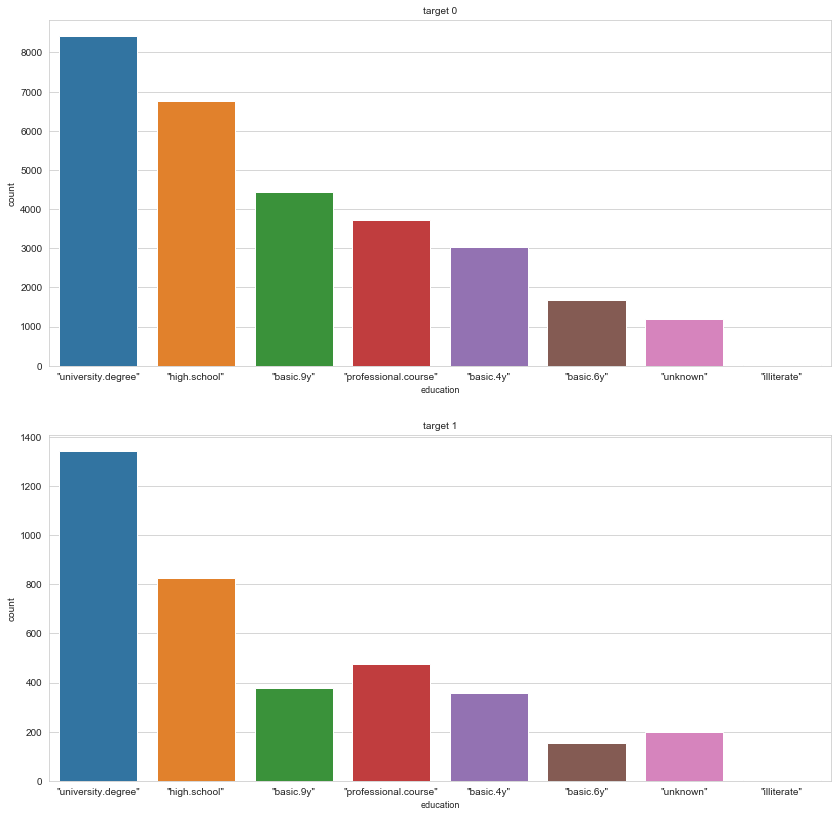

In [24]:
plot_feature_categ(train_df, 'education', target)

### Default

In [25]:
train_df['default'].unique()

array(['"unknown"', '"no"', '"yes"'], dtype=object)

In [26]:
default_cat = pd.get_dummies(train_df['default'], prefix='default', drop_first=False)
default_cat.columns = [col.replace('"', '') for col in default_cat.columns]
try:
    default_cat.drop(['default_yes'], axis=1, inplace=True)
except:
    pass

default_cat_test = pd.get_dummies(test_df['default'], prefix='default', drop_first=False)
default_cat_test.columns = [col.replace('"', '') for col in default_cat_test.columns]
try:
    default_cat_test.drop(['default_yes'], axis=1, inplace=True)
except:
    pass

categ_feat_test_dfs.append(default_cat_test)
categ_feat_dfs.append(default_cat)

<Figure size 432x288 with 0 Axes>

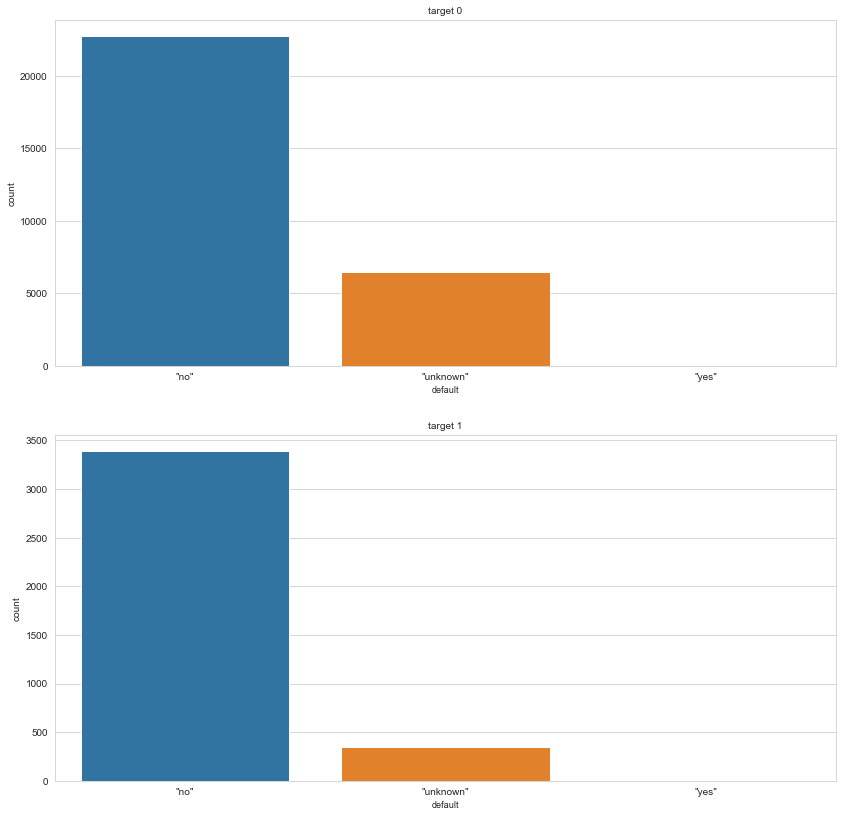

In [27]:
plot_feature_categ(train_df, 'default', target)

### Housing

In [28]:
train_df['housing'].unique()

array(['"yes"', '"no"', '"unknown"'], dtype=object)

In [29]:
housing_cat = pd.get_dummies(train_df['housing'], prefix='housing', drop_first=False)
housing_cat.columns = [col.replace('"', '') for col in housing_cat.columns]
housing_cat.drop(['housing_unknown'], axis=1, inplace=True)

housing_cat_test = pd.get_dummies(test_df['housing'], prefix='housing', drop_first=False)
housing_cat_test.columns = [col.replace('"', '') for col in housing_cat_test.columns]
housing_cat_test.drop(['housing_unknown'], axis=1, inplace=True)

categ_feat_test_dfs.append(housing_cat_test)
categ_feat_dfs.append(housing_cat)

<Figure size 432x288 with 0 Axes>

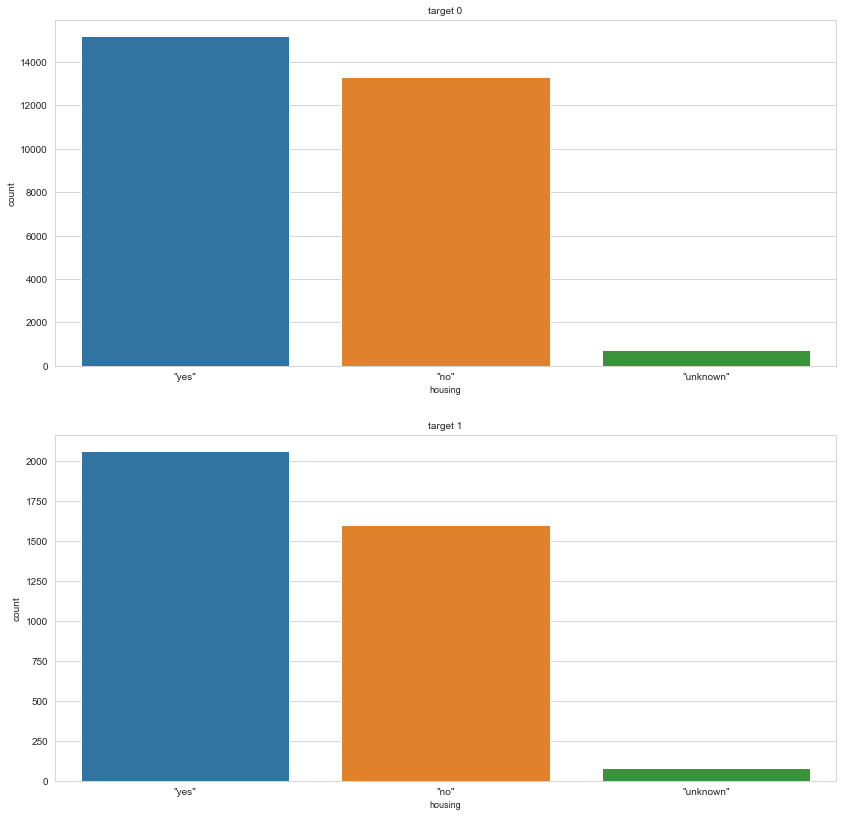

In [30]:
plot_feature_categ(train_df, 'housing', target)

### Loan

In [31]:
train_df['loan'].unique()

array(['"no"', '"yes"', '"unknown"'], dtype=object)

In [32]:
loan_cat = pd.get_dummies(train_df['loan'], prefix='loan', drop_first=False)
loan_cat.columns = [col.replace('"', '') for col in loan_cat.columns]
loan_cat.drop(['loan_unknown'], axis=1, inplace=True)

loan_cat_test = pd.get_dummies(test_df['loan'], prefix='loan', drop_first=False)
loan_cat_test.columns = [col.replace('"', '') for col in loan_cat_test.columns]
loan_cat_test.drop(['loan_unknown'], axis=1, inplace=True)

categ_feat_test_dfs.append(loan_cat_test)
categ_feat_dfs.append(loan_cat)

<Figure size 432x288 with 0 Axes>

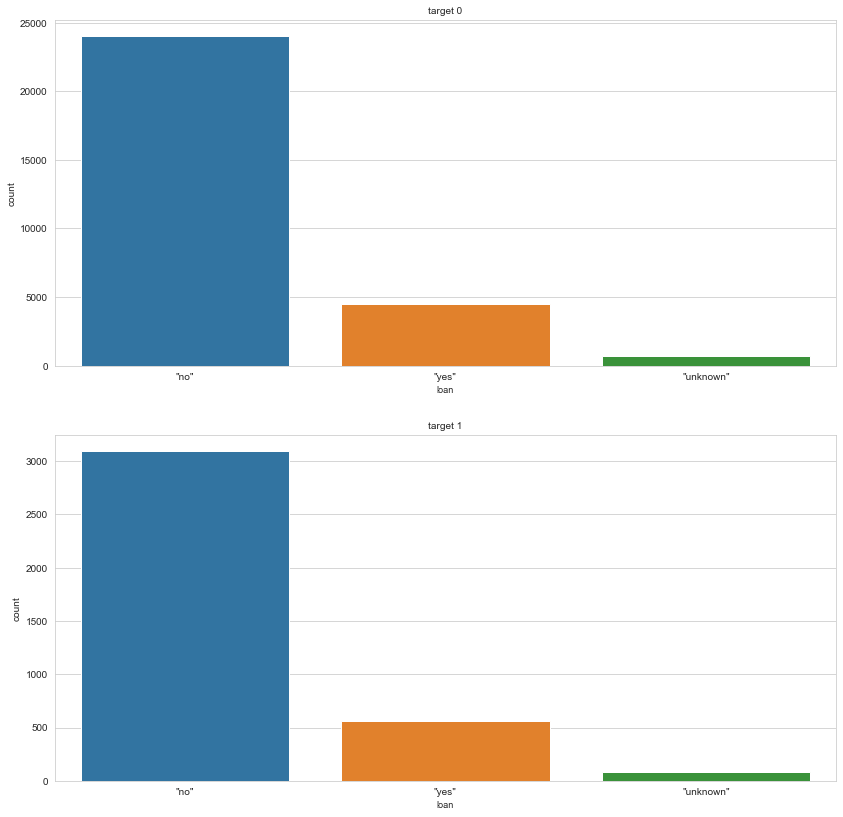

In [33]:
plot_feature_categ(train_df, 'loan', target)

### Contact

In [34]:
train_df['contact'].unique()

array(['"telephone"', '"cellular"'], dtype=object)

In [35]:
contact_cat = pd.get_dummies(train_df['contact'], prefix='contact', drop_first=False)
contact_cat.columns = [col.replace('"', '') for col in contact_cat.columns]
contact_cat.drop(['contact_telephone'], axis=1, inplace=True)

contact_cat_test = pd.get_dummies(test_df['contact'], prefix='contact', drop_first=False)
contact_cat_test.columns = [col.replace('"', '') for col in contact_cat_test.columns]
contact_cat_test.drop(['contact_telephone'], axis=1, inplace=True)

categ_feat_test_dfs.append(contact_cat_test)
categ_feat_dfs.append(contact_cat)

<Figure size 432x288 with 0 Axes>

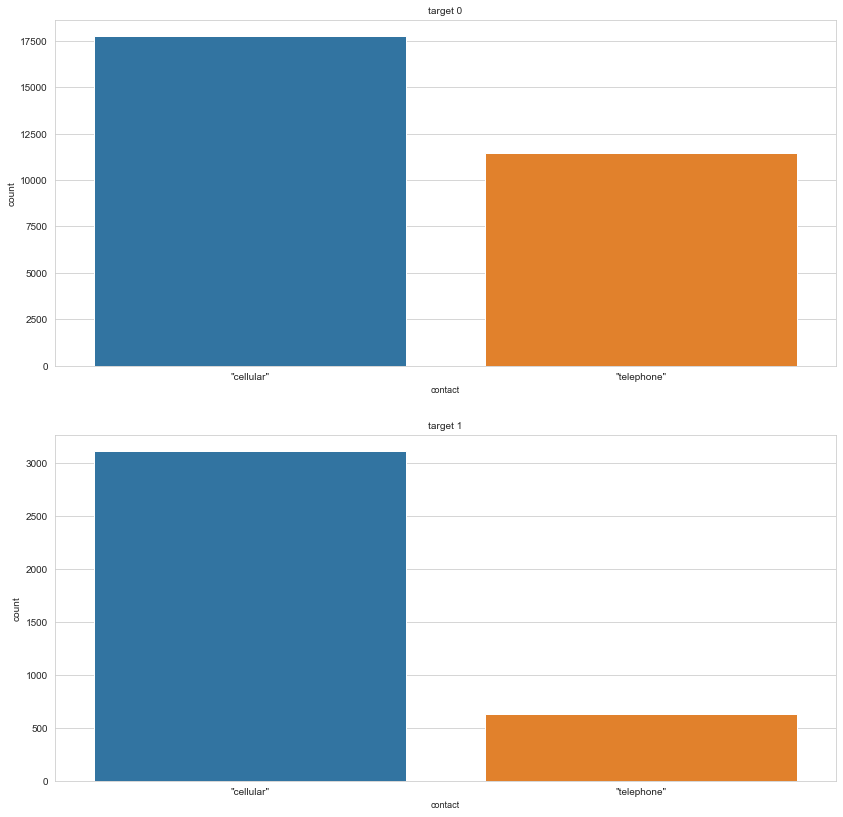

In [36]:
plot_feature_categ(train_df, 'contact', target)

### Month

In [37]:
train_df['month'].unique()

array(['"may"', '"jul"', '"apr"', '"nov"', '"jun"', '"aug"', '"sep"',
       '"oct"', '"dec"', '"mar"'], dtype=object)

In [38]:
month_cat = pd.get_dummies(train_df['month'], prefix='month', drop_first=False)
month_cat.columns = [col.replace('"', '') for col in month_cat.columns]
month_cat.drop(['month_mar'], axis=1, inplace=True)

month_cat_test = pd.get_dummies(test_df['month'], prefix='month', drop_first=False)
month_cat_test.columns = [col.replace('"', '') for col in month_cat_test.columns]
month_cat_test.drop(['month_mar'], axis=1, inplace=True)

categ_feat_test_dfs.append(month_cat_test)
categ_feat_dfs.append(month_cat)

<Figure size 432x288 with 0 Axes>

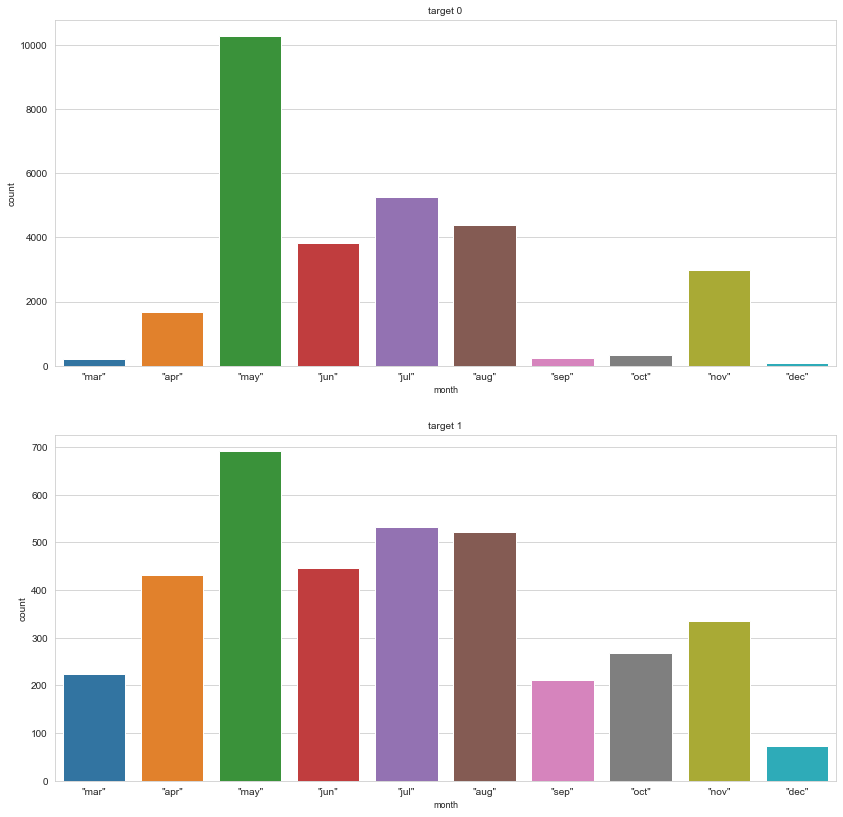

In [39]:
order = ['"mar"', '"apr"', '"may"', '"jun"', '"jul"', '"aug"', '"sep"', '"oct"', '"nov"', '"dec"']
plot_feature_categ(train_df, 'month', target, order=order)

### Day of week

In [40]:
train_df['day_of_week'].unique()

array(['"fri"', '"thu"', '"tue"', '"mon"', '"wed"'], dtype=object)

In [41]:
day_cat = pd.get_dummies(train_df['day_of_week'], prefix='day', drop_first=False)
day_cat.columns = [col.replace('"', '') for col in day_cat.columns]
day_cat.drop(['day_fri'], axis=1, inplace=True)

day_cat_test = pd.get_dummies(test_df['day_of_week'], prefix='day', drop_first=False)
day_cat_test.columns = [col.replace('"', '') for col in day_cat_test.columns]
day_cat_test.drop(['day_fri'], axis=1, inplace=True)

categ_feat_test_dfs.append(day_cat_test)
categ_feat_dfs.append(day_cat)

<Figure size 432x288 with 0 Axes>

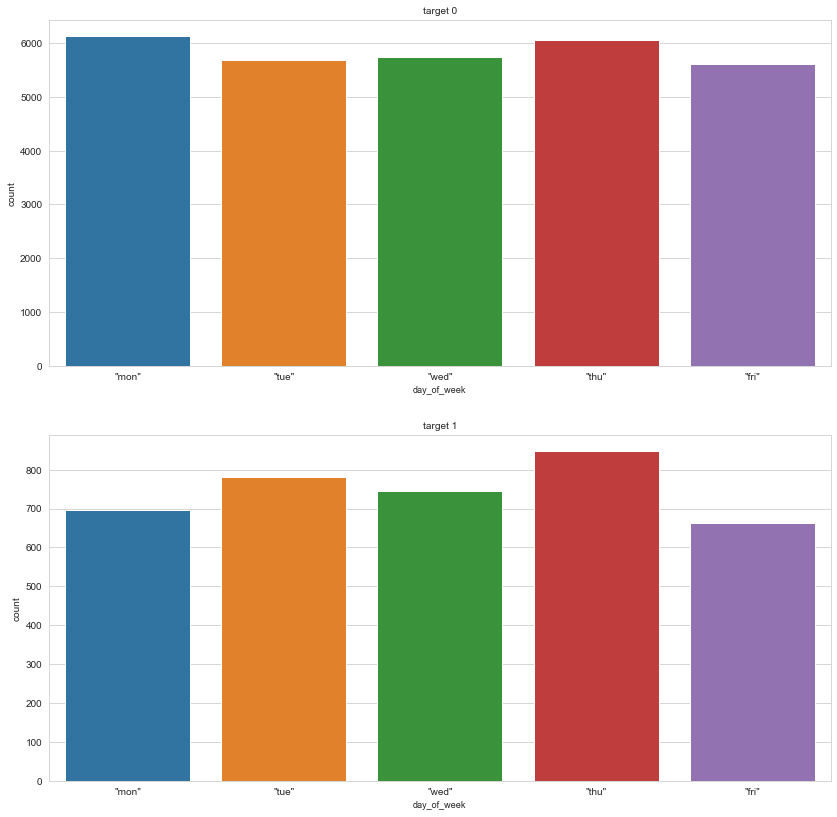

In [42]:
order = ['"mon"', '"tue"', '"wed"', '"thu"', '"fri"']
plot_feature_categ(train_df, 'day_of_week', target, order=order)

### Poutcome

In [43]:
train_df['poutcome'].unique()

array(['"nonexistent"', '"failure"', '"success"'], dtype=object)

In [44]:
poutcome_cat = pd.get_dummies(train_df['poutcome'], prefix='poutcome', drop_first=False)
poutcome_cat.columns = [col.replace('"', '') for col in poutcome_cat.columns]
poutcome_cat.drop(['poutcome_nonexistent'], axis=1, inplace=True)

poutcome_cat_test = pd.get_dummies(test_df['poutcome'], prefix='poutcome', drop_first=False)
poutcome_cat_test.columns = [col.replace('"', '') for col in poutcome_cat_test.columns]
poutcome_cat_test.drop(['poutcome_nonexistent'], axis=1, inplace=True)

categ_feat_test_dfs.append(poutcome_cat_test)
categ_feat_dfs.append(poutcome_cat)

<Figure size 432x288 with 0 Axes>

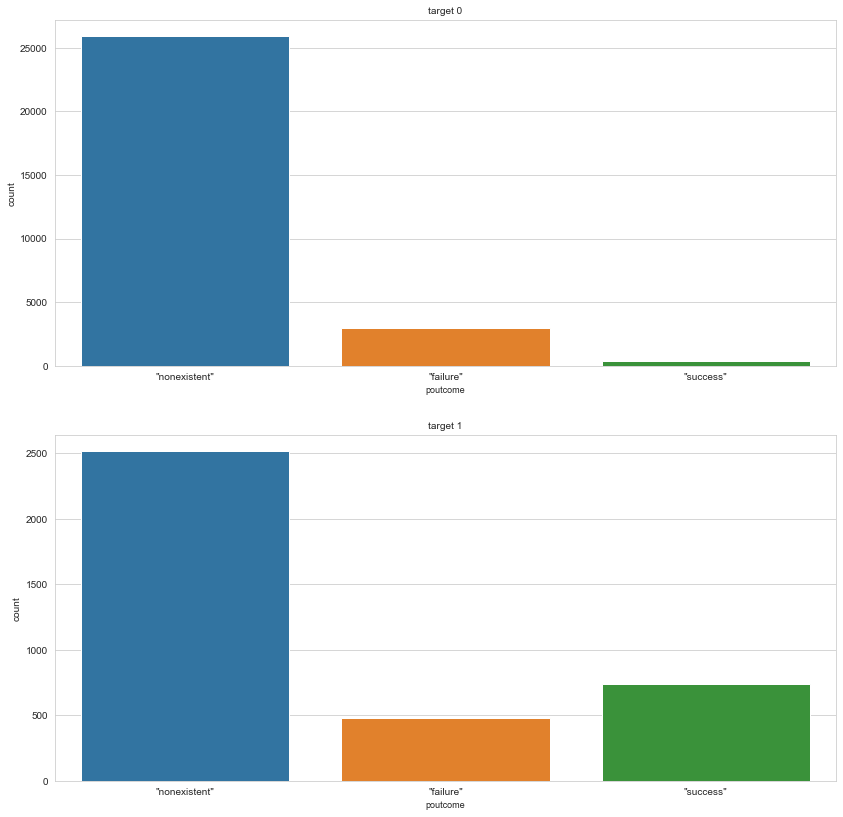

In [45]:
plot_feature_categ(train_df, 'poutcome', target)


## <a id='32'>Density plots of features</a>  

Let's show now the density plot of variables in train dataset (numerical features).

We represent with different colors the distribution for values with **target** value **0** and **1**.

The first 10 numerical values are displayed in the following cell.

<Figure size 432x288 with 0 Axes>

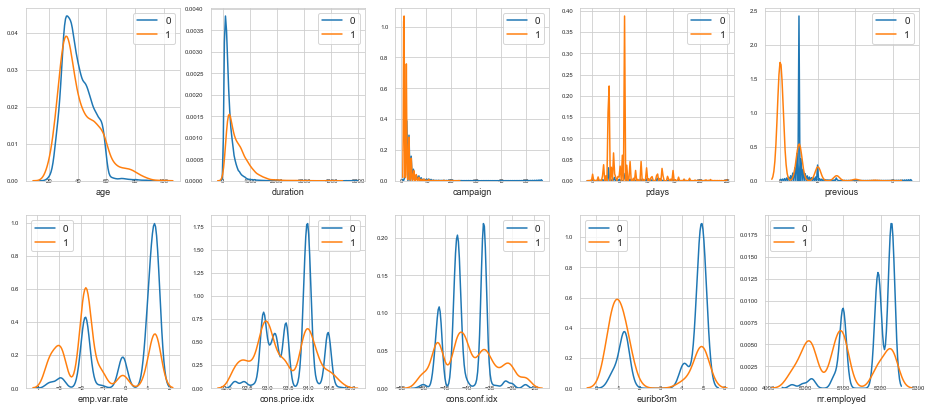

In [46]:
t0 = train_df.loc[train_df[target] == 0]
t1 = train_df.loc[train_df[target] == 1]
plot_feature_distribution(t0, t1, '0', '1', numer_feat)

We can observe that there is a considerable number of features with significant different distribution for the two target values.

For example, **duration**, **pdays**, **previous**, **emp.var.rate**, **cons.price.idx** and **nr.employed**.

Also some features, like **emp.var.rate**, **cons.price.idx**, **cons.conf.idx**, **var_55** and **euribor3m** show a distribution that resambles to a multivariate distribution. This also is an early indicator that a tree-based model can be very performant.

We will take this into consideration in the future for the selection of the features for our prediction model.  

Le't s now look to the distribution of the same features in parallel in train and test datasets. 

The first 10 values are displayed in the following cell.

<Figure size 432x288 with 0 Axes>

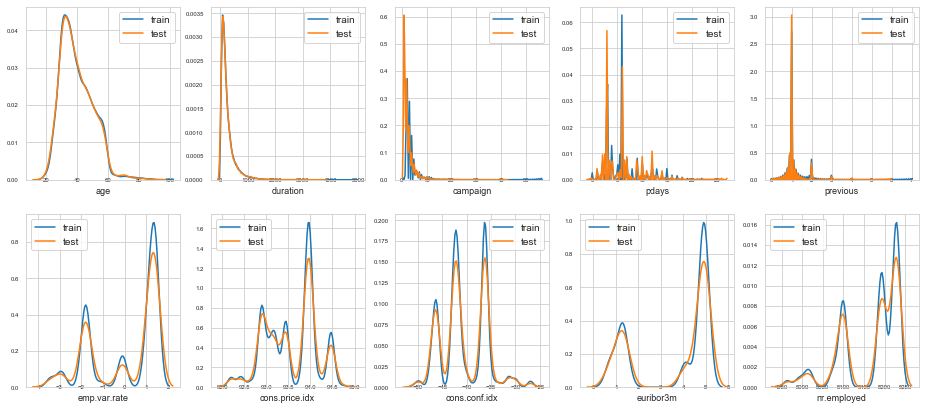

In [47]:
plot_feature_distribution(train_df, test_df, 'train', 'test', numer_feat)

The train and test seems not to be very well ballanced with respect with distribution of the numeric variables, something that could affect the performance of the final model.  

## <a id='33'>Distribution of mean and std</a>  

Let's check the distribution of the mean values (numerical) per row in the train and test set.

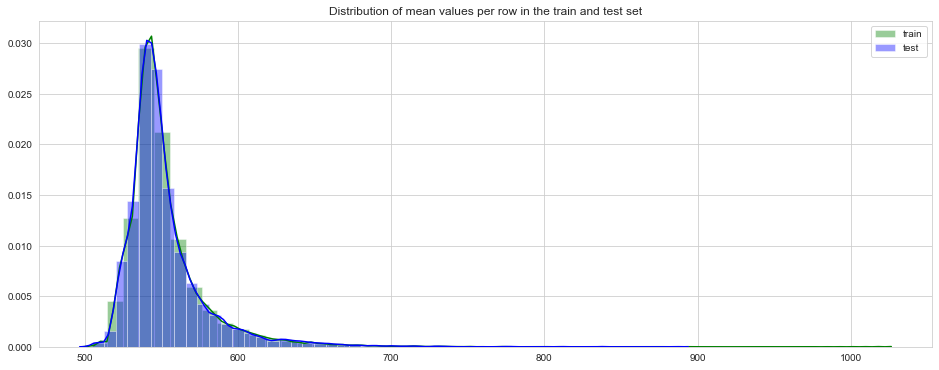

In [48]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[:-1]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[numer_feat].mean(axis=1),color="green", kde=True,bins=50, label='train')
sns.distplot(test_df[numer_feat].mean(axis=1),color="blue", kde=True,bins=50, label='test')
plt.legend()
plt.show()

Let's check the distribution of the mean values per columns in the train and test set.

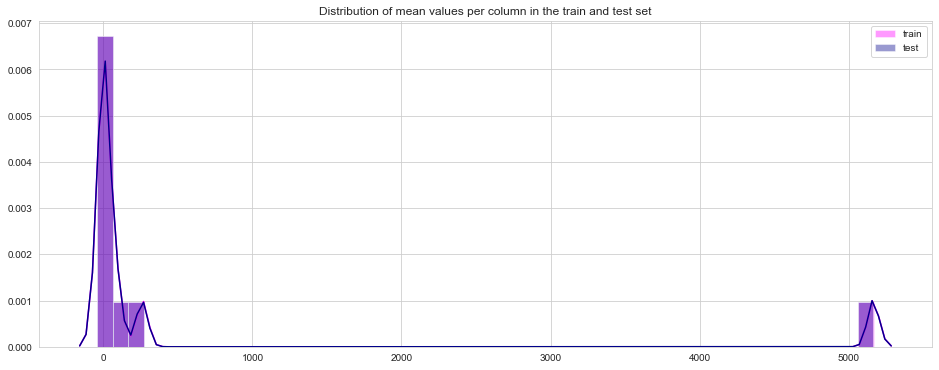

In [49]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[numer_feat].mean(axis=0),color="magenta",kde=True,bins=50, label='train')
sns.distplot(test_df[numer_feat].mean(axis=0),color="darkblue", kde=True,bins=50, label='test')
plt.legend()
plt.show()

Let's show the distribution of standard deviation of values per row for train and test datasets.

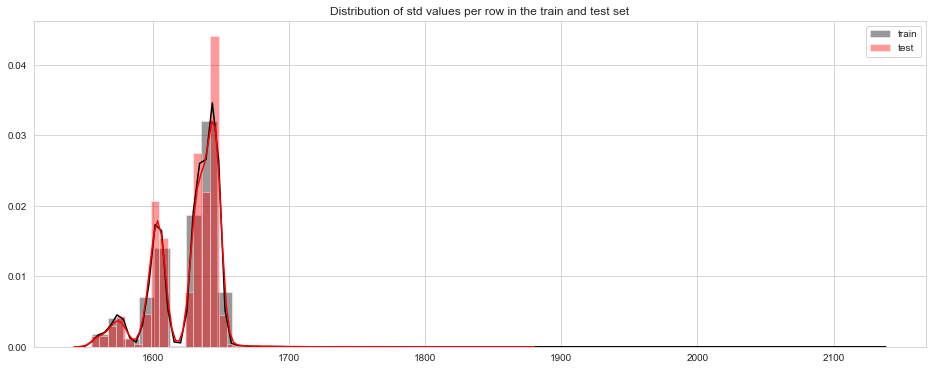

In [50]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[numer_feat].std(axis=1),color="black", kde=True,bins=50, label='train')
sns.distplot(test_df[numer_feat].std(axis=1),color="red", kde=True,bins=50, label='test')
plt.legend();plt.show()

Let's check the distribution of the standard deviation of values per columns in the train and test datasets.

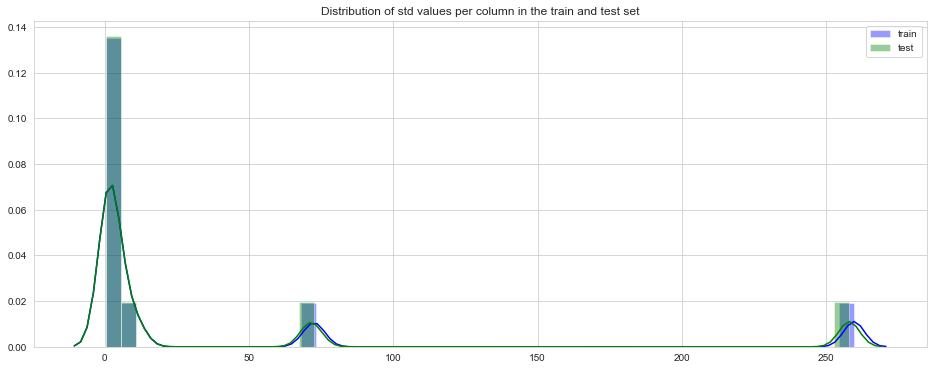

In [51]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[numer_feat].std(axis=0),color="blue",kde=True,bins=50, label='train')
sns.distplot(test_df[numer_feat].std(axis=0),color="green", kde=True,bins=50, label='test')
plt.legend(); plt.show()

Let's check now the distribution of the mean value per row in the train dataset, grouped by value of target.

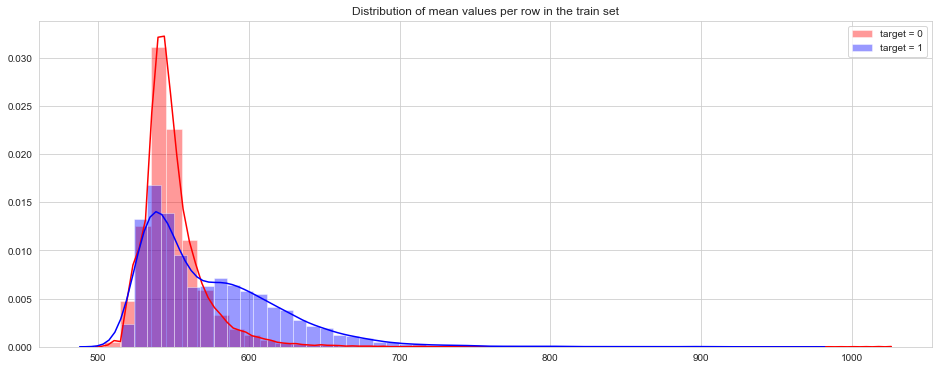

In [52]:
t0 = train_df.loc[train_df[target] == 0]
t1 = train_df.loc[train_df[target] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[numer_feat].mean(axis=1),color="red", kde=True,bins=50, label='target = 0')
sns.distplot(t1[numer_feat].mean(axis=1),color="blue", kde=True,bins=50, label='target = 1')
plt.legend(); plt.show()

Let's check now the distribution of the mean value per column in the train dataset, grouped by value of target.

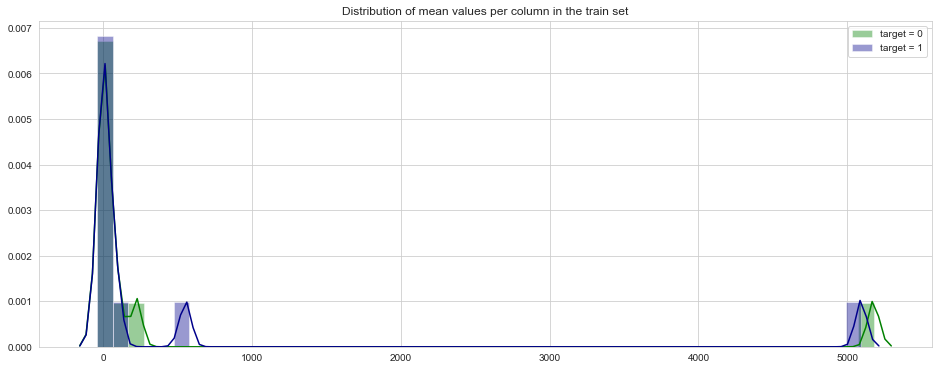

In [53]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[numer_feat].mean(axis=0),color="green", kde=True,bins=50, label='target = 0')
sns.distplot(t1[numer_feat].mean(axis=0),color="darkblue", kde=True,bins=50, label='target = 1')
plt.legend(); plt.show()

## <a id='34'>Distribution of min and max</a>  

Let's check the distribution of min per row in the train and test set.

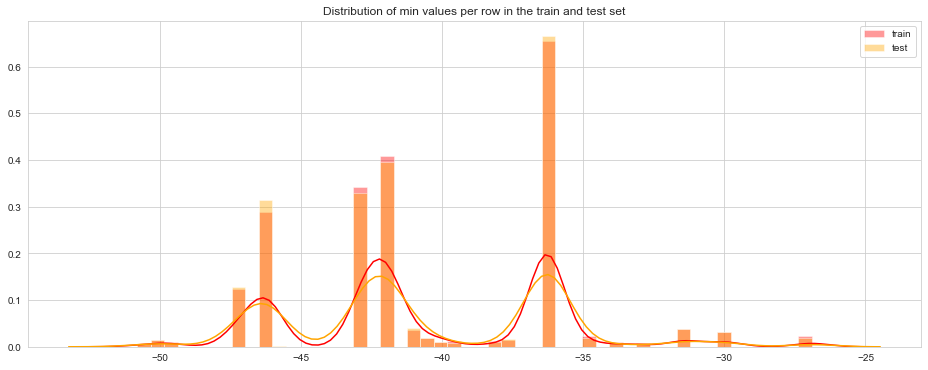

In [54]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train_df[numer_feat].min(axis=1),color="red", kde=True,bins=50, label='train')
sns.distplot(test_df[numer_feat].min(axis=1),color="orange", kde=True,bins=50, label='test')
plt.legend()
plt.show()

A long variation that centres around clusters is observed.

Let's now show the distribution of min per column in the train and test set.

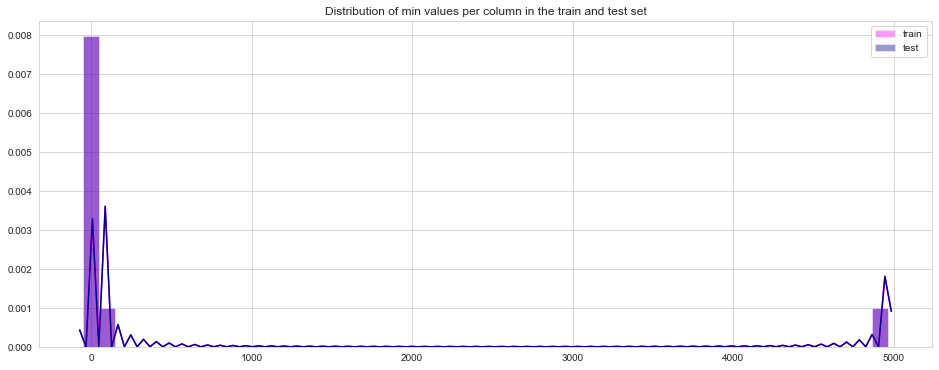

In [55]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train and test set")
sns.distplot(train_df[numer_feat].min(axis=0),color="magenta", kde=True,bins=50, label='train')
sns.distplot(test_df[numer_feat].min(axis=0),color="darkblue", kde=True,bins=50, label='test')
plt.legend()
plt.show()

Yet again, one (or very few) columns has very big values, compared to the rest (majority) of the columns.

Let's check now the distribution of max values per rows for train and test set.

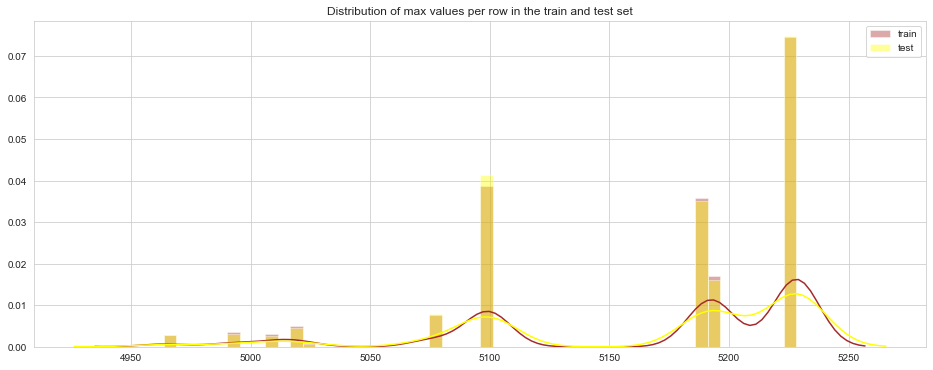

In [56]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train_df[numer_feat].max(axis=1),color="brown", kde=True,bins=50, label='train')
sns.distplot(test_df[numer_feat].max(axis=1),color="yellow", kde=True,bins=50, label='test')
plt.legend()
plt.show()

Let's show now the max distribution on columns for train and test set.

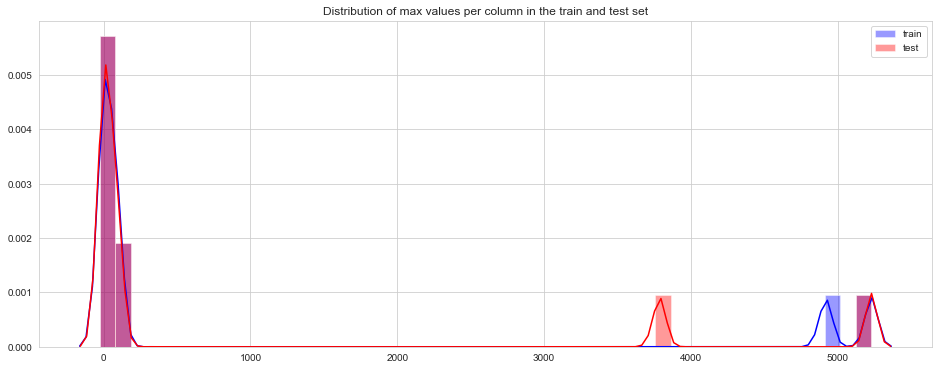

In [57]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train and test set")
sns.distplot(train_df[numer_feat].max(axis=0),color="blue", kde=True,bins=50, label='train')
sns.distplot(test_df[numer_feat].max(axis=0),color="red", kde=True,bins=50, label='test')
plt.legend()
plt.show()

Let's show now the distributions of min values per row in train set, separated on the values of target (0 and 1).

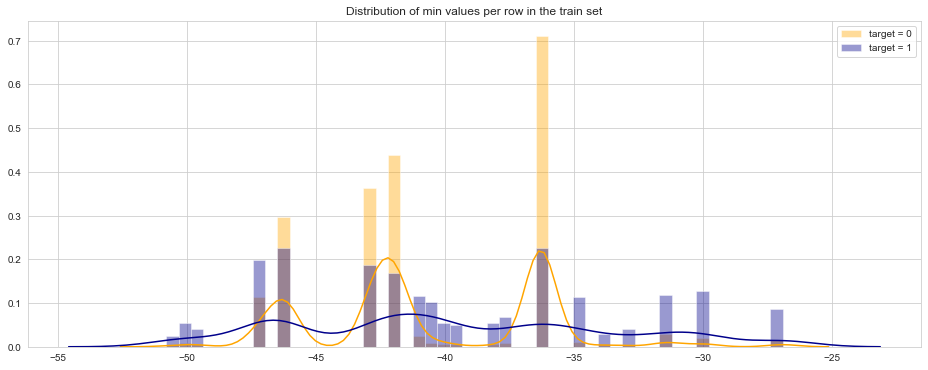

In [58]:
t0 = train_df.loc[train_df[target] == 0]
t1 = train_df.loc[train_df[target] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[numer_feat].min(axis=1),color="orange", kde=True,bins=50, label='target = 0')
sns.distplot(t1[numer_feat].min(axis=1),color="darkblue", kde=True,bins=50, label='target = 1')
plt.legend(); plt.show()

We show here the distribution of min values per columns in train set.

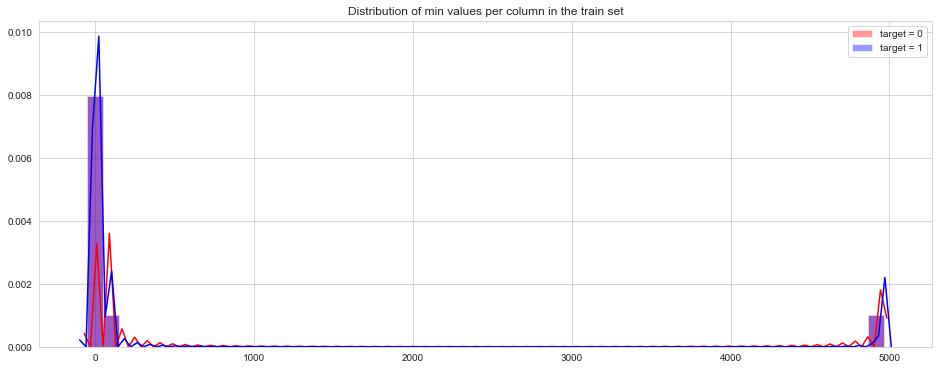

In [59]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[numer_feat].min(axis=0),color="red", kde=True,bins=50, label='target = 0')
sns.distplot(t1[numer_feat].min(axis=0),color="blue", kde=True,bins=50, label='target = 1')
plt.legend(); plt.show()

Let's show now the distribution of max values per row in the train set.

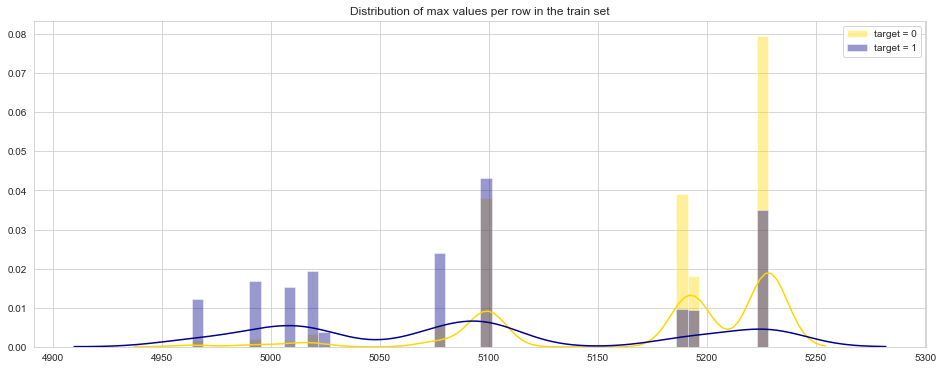

In [60]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[numer_feat].max(axis=1),color="gold", kde=True,bins=50, label='target = 0')
sns.distplot(t1[numer_feat].max(axis=1),color="darkblue", kde=True,bins=50, label='target = 1')
plt.legend(); plt.show()

Let's show also the distribution of max values per columns in the train set.

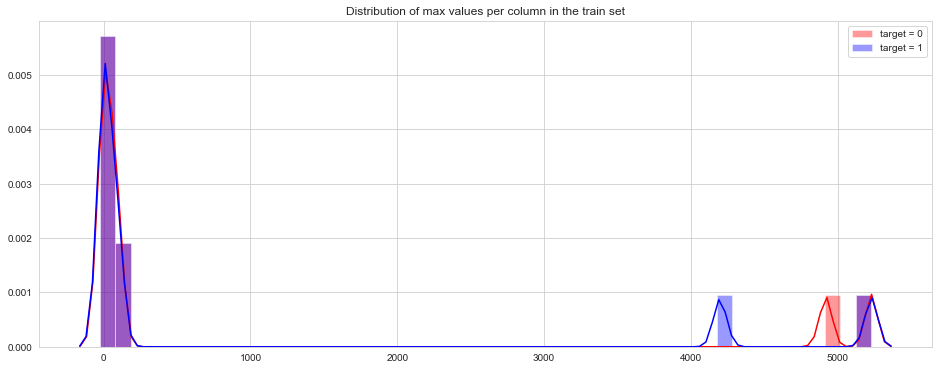

In [61]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[numer_feat].max(axis=0),color="red", kde=True,bins=50, label='target = 0')
sns.distplot(t1[numer_feat].max(axis=0),color="blue", kde=True,bins=50, label='target = 1')
plt.legend(); plt.show()

## <a id='35'>Distribution of skew and kurtosis</a>  

Let's see now what is the distribution of skew values per rows and columns.

Let's see first the distribution of skewness calculated per rows in train and test sets.

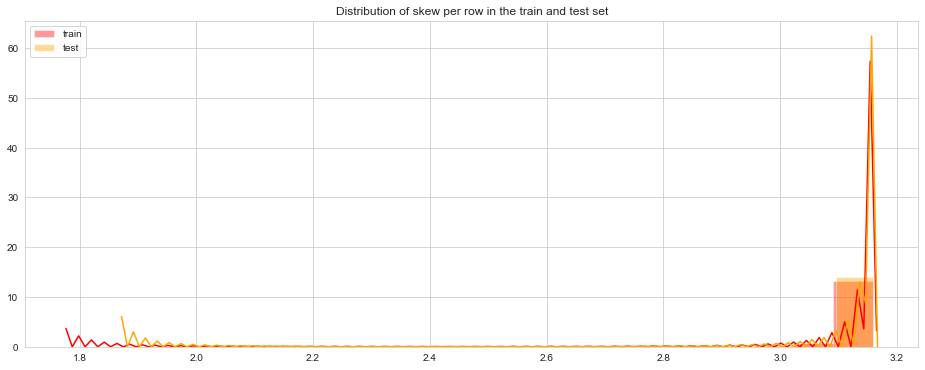

In [62]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_df[numer_feat].skew(axis=1),color="red", kde=True,bins=20, label='train')
sns.distplot(test_df[numer_feat].skew(axis=1),color="orange", kde=True,bins=20, label='test')
plt.legend()
plt.show()

Let's see first the distribution of skewness calculated per columns in train and test set.

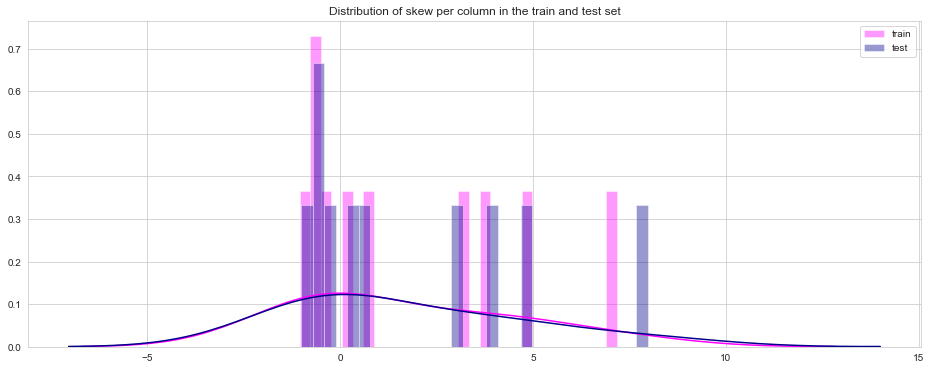

In [63]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train_df[numer_feat].skew(axis=0),color="magenta", kde=True,bins=30, label='train')
sns.distplot(test_df[numer_feat].skew(axis=0),color="darkblue", kde=True,bins=30, label='test')
plt.legend()
plt.show()

Let's see now what is the distribution of kurtosis values per rows and columns.

Let's see first the distribution of kurtosis calculated per rows in train and test sets.

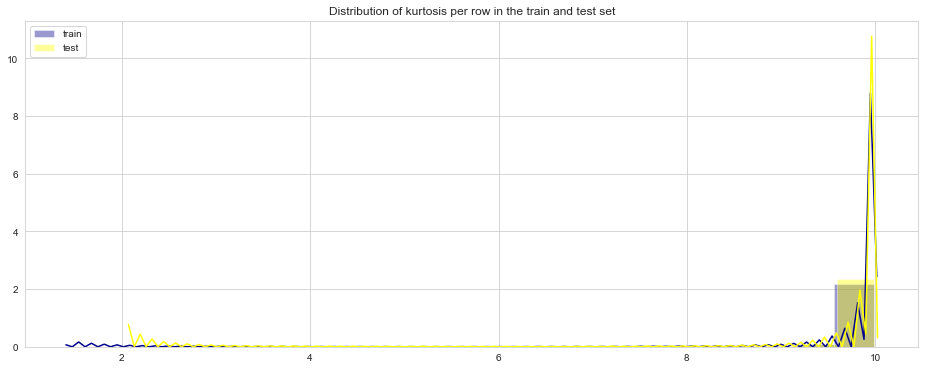

In [64]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train_df[numer_feat].kurtosis(axis=1),color="darkblue", kde=True,bins=20, label='train')
sns.distplot(test_df[numer_feat].kurtosis(axis=1),color="yellow", kde=True,bins=20, label='test')
plt.legend()
plt.show()

Let's see first the distribution of kurtosis calculated per columns in train and test sets.

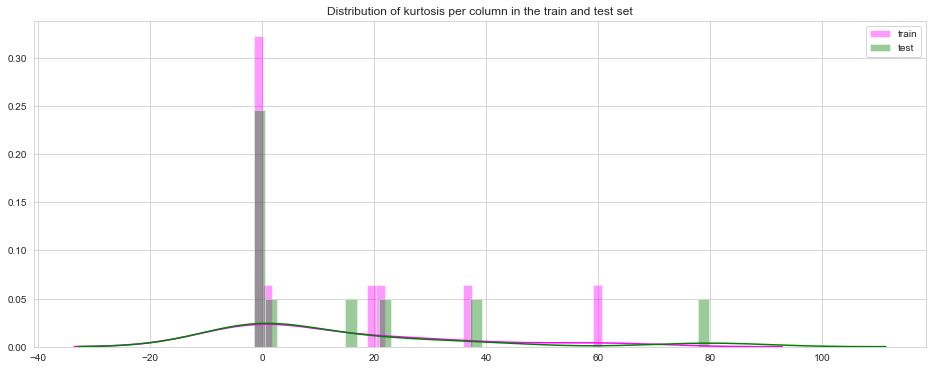

In [65]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train_df[numer_feat].kurtosis(axis=0),color="magenta", kde=True,bins=40, label='train')
sns.distplot(test_df[numer_feat].kurtosis(axis=0),color="green", kde=True,bins=40, label='test')
plt.legend()
plt.show()

Let's see now the distribution of skewness on rows in train separated for values of target 0 and 1.

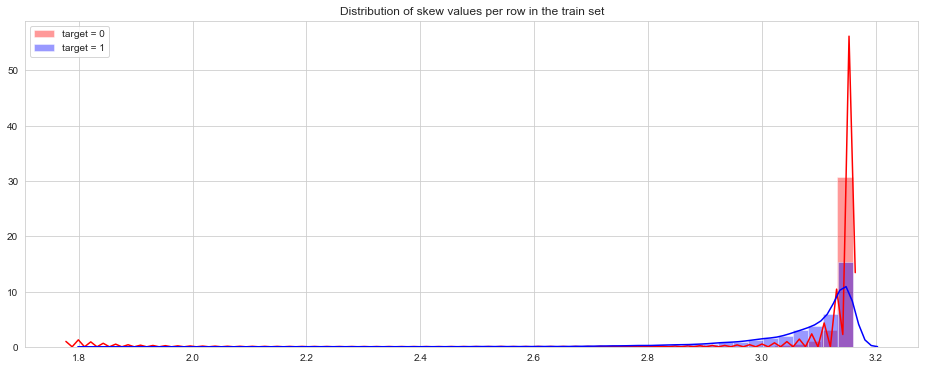

In [66]:
t0 = train_df.loc[train_df[target] == 0]
t1 = train_df.loc[train_df[target] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[numer_feat].skew(axis=1),color="red", kde=True,bins=50, label='target = 0')
sns.distplot(t1[numer_feat].skew(axis=1),color="blue", kde=True,bins=50, label='target = 1')
plt.legend(); plt.show()

Let's see now the distribution of skewness on columns in train separated for values of target 0 and 1.

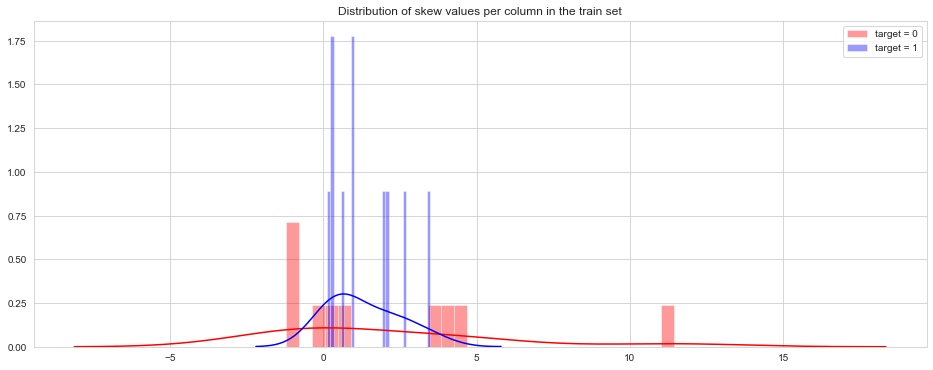

In [67]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[numer_feat].skew(axis=0),color="red", kde=True,bins=30, label='target = 0')
sns.distplot(t1[numer_feat].skew(axis=0),color="blue", kde=True,bins=30, label='target = 1')
plt.legend(); plt.show()

Let's see now the distribution of kurtosis on rows in train separated for values of target 0 and 1.

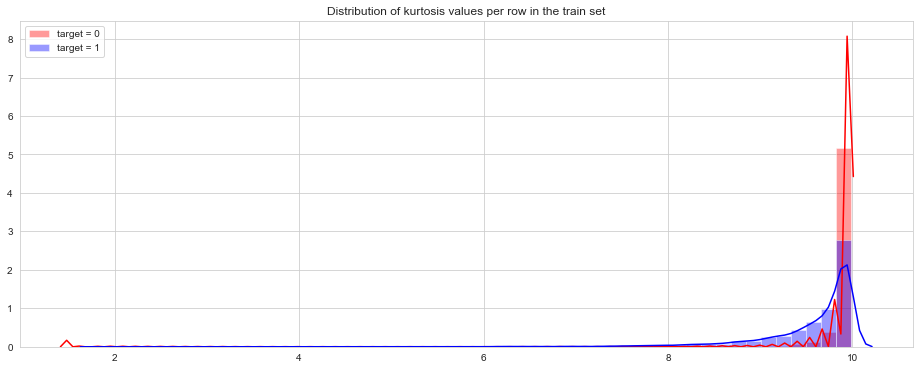

In [68]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[numer_feat].kurtosis(axis=1),color="red", kde=True,bins=50, label='target = 0')
sns.distplot(t1[numer_feat].kurtosis(axis=1),color="blue", kde=True,bins=50, label='target = 1')
plt.legend(); plt.show()

Let's see now the distribution of kurtosis on columns in train separated for values of target 0 and 1.

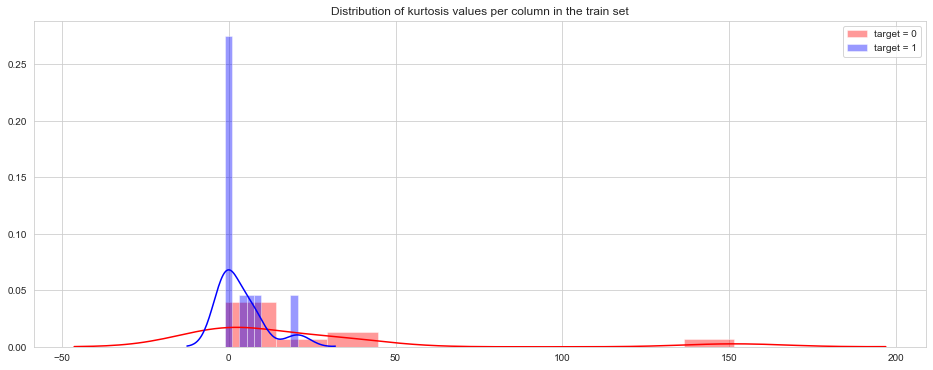

In [69]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[numer_feat].kurtosis(axis=0),color="red", kde=True,bins=10, label='target = 0')
sns.distplot(t1[numer_feat].kurtosis(axis=0),color="blue", kde=True,bins=10, label='target = 1')
plt.legend(); plt.show()

## <a id='36'>Features correlation (including categorical)</a>  

We calculate now the correlations between the features in train set.  
The following table shows the first 10 least correlated features.

In [70]:
%%time
correlations = train_df[numer_feat].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

Wall time: 11.4 ms


level_0         level_1         0
0             age        duration  0.000960
1        duration             age  0.000960
2  cons.price.idx             age  0.001304
3             age  cons.price.idx  0.001304
4    emp.var.rate             age  0.003197
5             age    emp.var.rate  0.003197
6        campaign             age  0.006921
7             age        campaign  0.006921
8   cons.conf.idx        duration  0.007287
9        duration   cons.conf.idx  0.007287

Let's look to the top most correlated features, besides the same feature pairs.

In [71]:
correlations.tail(10)

level_0         level_1         0
80  cons.price.idx       euribor3m  0.686035
81       euribor3m  cons.price.idx  0.686035
82  cons.price.idx    emp.var.rate  0.774582
83    emp.var.rate  cons.price.idx  0.774582
84    emp.var.rate     nr.employed  0.906408
85     nr.employed    emp.var.rate  0.906408
86     nr.employed       euribor3m  0.945150
87       euribor3m     nr.employed  0.945150
88    emp.var.rate       euribor3m  0.971962
89       euribor3m    emp.var.rate  0.971962

Let's look to the top most correlated features, besides the same feature pairs, including the categorical features.

In [72]:
%%time
dfs_for_concat = [train_df.drop(columns=categ_feat, axis=1)]
dfs_for_concat = dfs_for_concat + categ_feat_dfs
train_df_total = pd.concat(dfs_for_concat, axis=1, join='outer')
train_df_total = train_df_total.drop(columns=['y'], axis=1)
train_df_total['y'] = train_df['y']

correlations2 = train_df_total[numer_feat].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations2 = correlations2[correlations2['level_0'] != correlations2['level_1']]
correlations2.head(10)

Wall time: 59 ms


level_0         level_1         0
0             age        duration  0.000960
1        duration             age  0.000960
2  cons.price.idx             age  0.001304
3             age  cons.price.idx  0.001304
4    emp.var.rate             age  0.003197
5             age    emp.var.rate  0.003197
6        campaign             age  0.006921
7             age        campaign  0.006921
8   cons.conf.idx        duration  0.007287
9        duration   cons.conf.idx  0.007287

Let's look to the top most correlated features, besides the same feature pairs, including the categorical features.

In [73]:
correlations2.tail(10)

level_0         level_1         0
80  cons.price.idx       euribor3m  0.686035
81       euribor3m  cons.price.idx  0.686035
82  cons.price.idx    emp.var.rate  0.774582
83    emp.var.rate  cons.price.idx  0.774582
84    emp.var.rate     nr.employed  0.906408
85     nr.employed    emp.var.rate  0.906408
86     nr.employed       euribor3m  0.945150
87       euribor3m     nr.employed  0.945150
88    emp.var.rate       euribor3m  0.971962
89       euribor3m    emp.var.rate  0.971962

In [74]:
# creating test_df_total
dfs_for_concat = [test_df.drop(columns=categ_feat, axis=1)]
dfs_for_concat = dfs_for_concat + categ_feat_test_dfs
test_df_total = pd.concat(dfs_for_concat, axis=1, join='outer')
test_df_total = test_df_total.drop(columns=['y'], axis=1)
test_df_total['y'] = test_df['y']

Visualise correlations on **Train Dataset**:

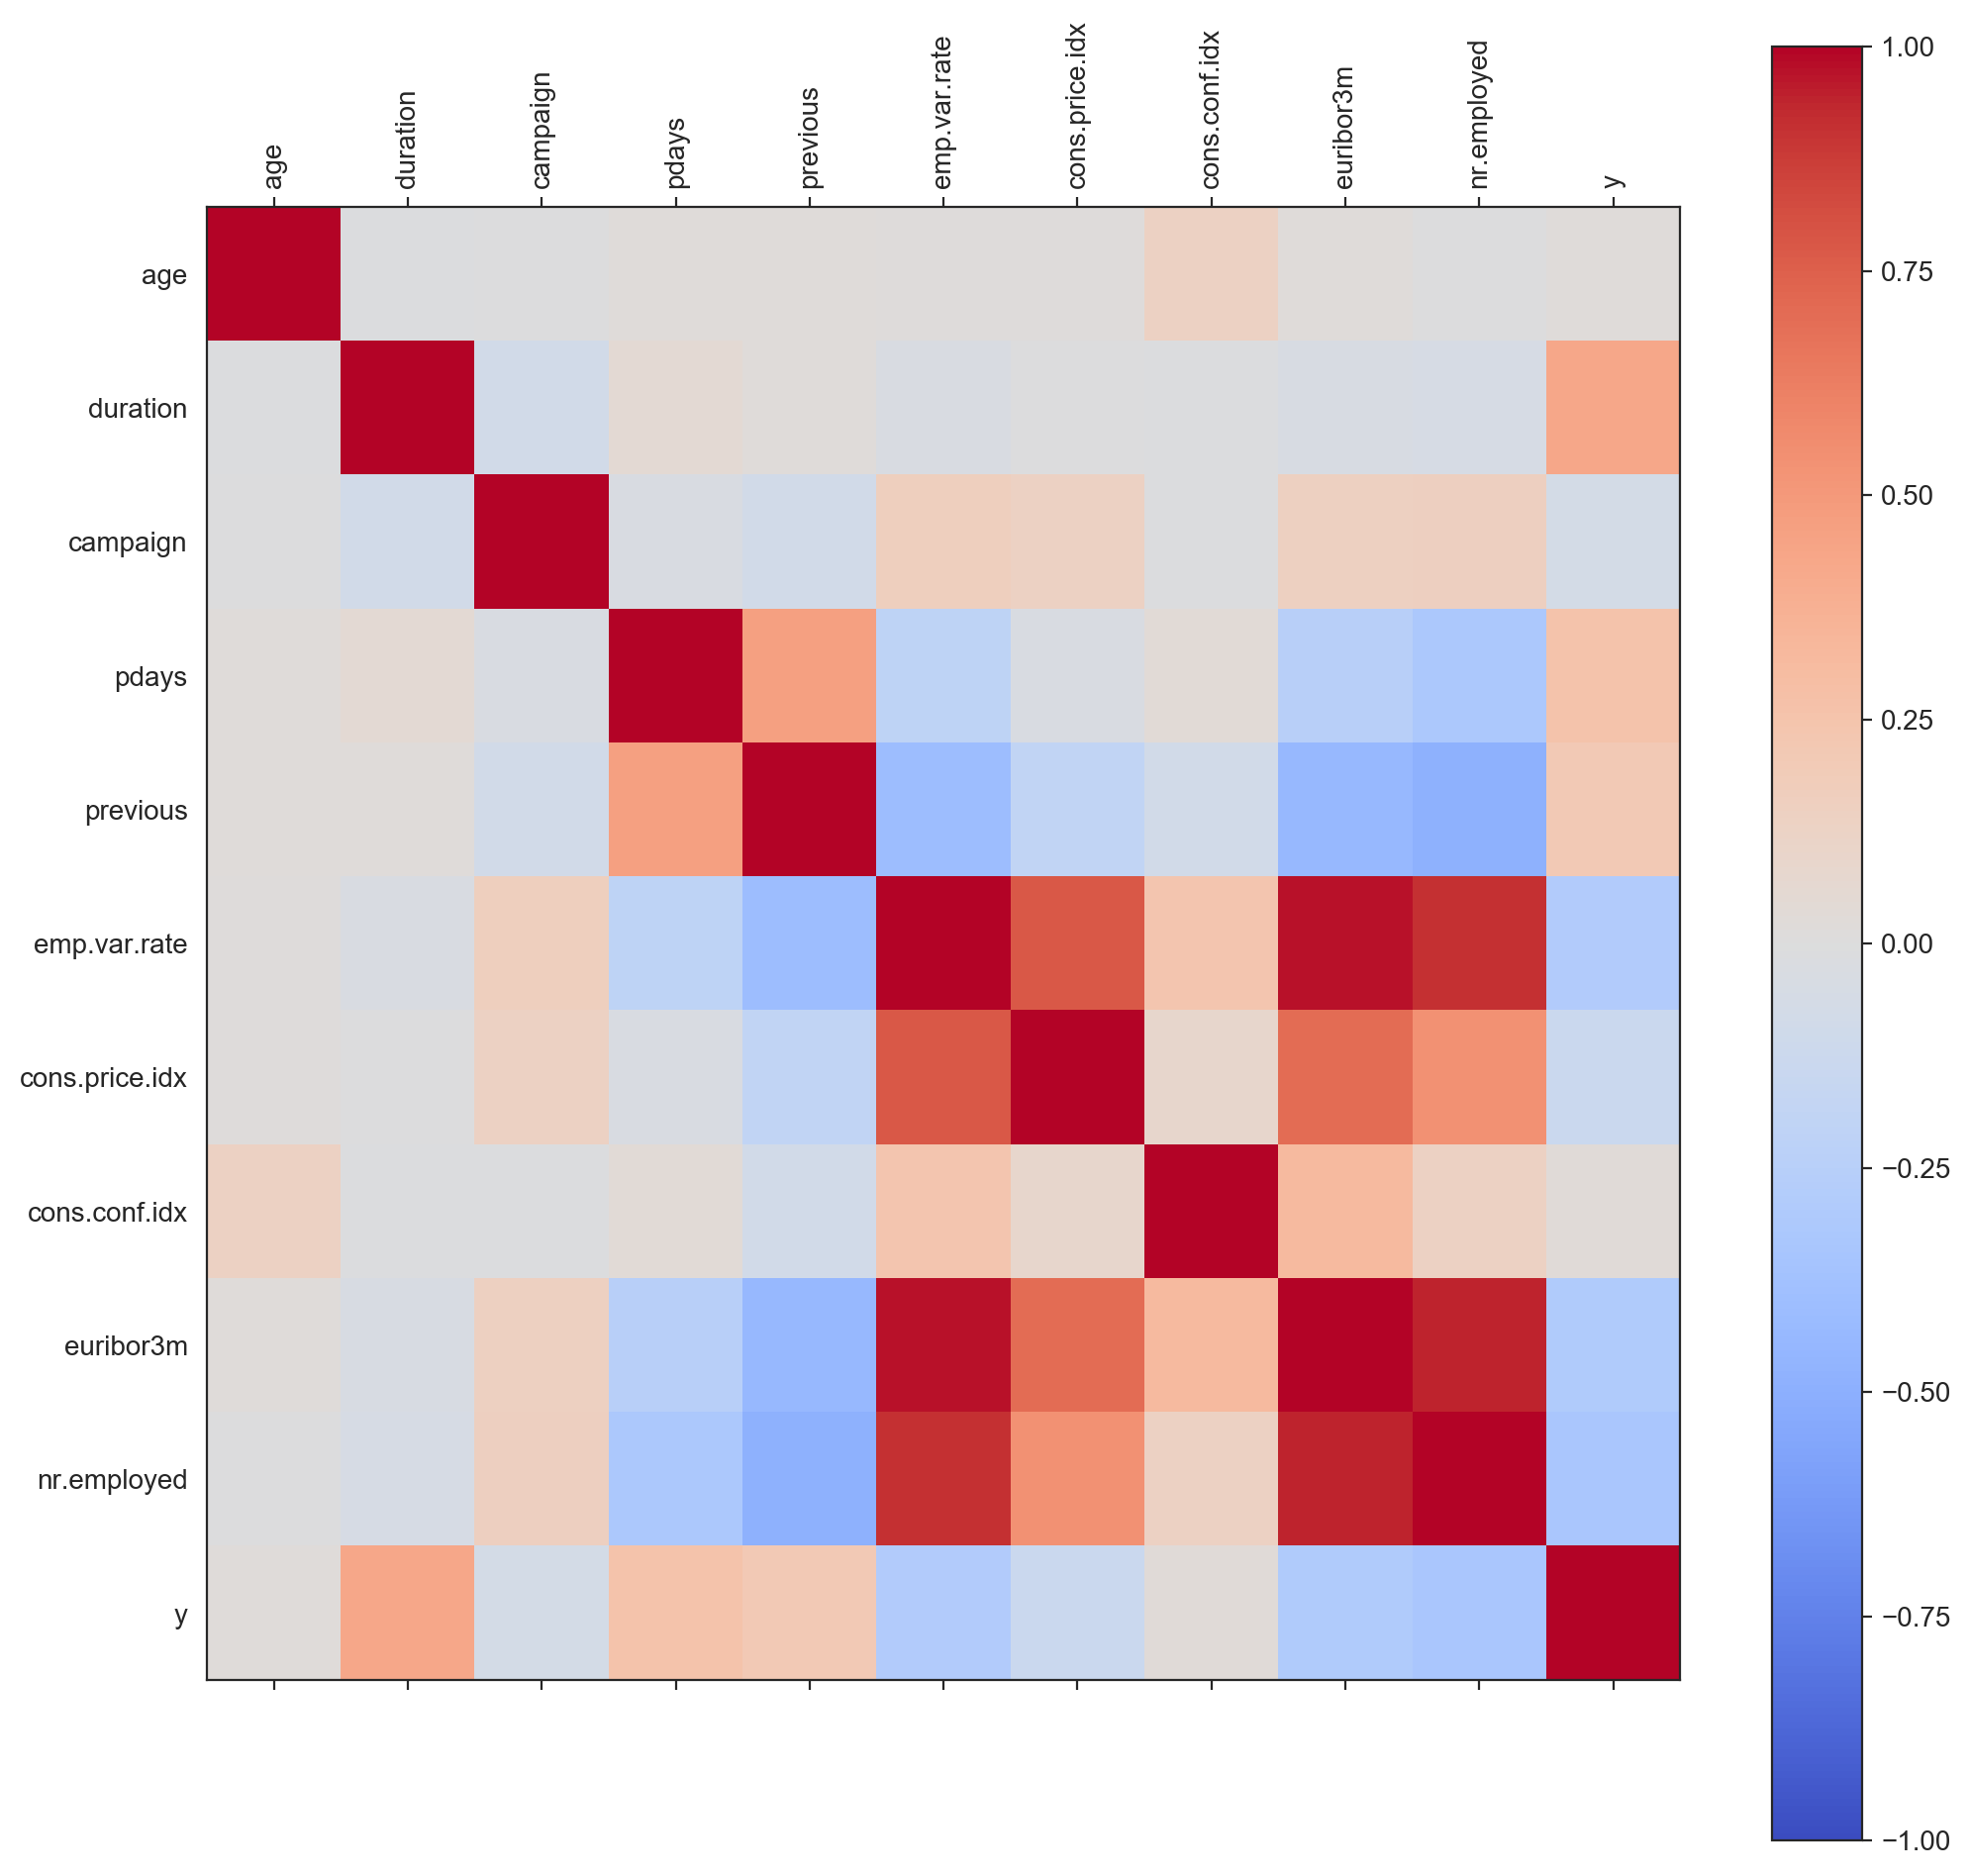

In [75]:
corr_heatmap_plot(test_df, cmap='coolwarm')

Visualise correlations on **Test Dataset**:

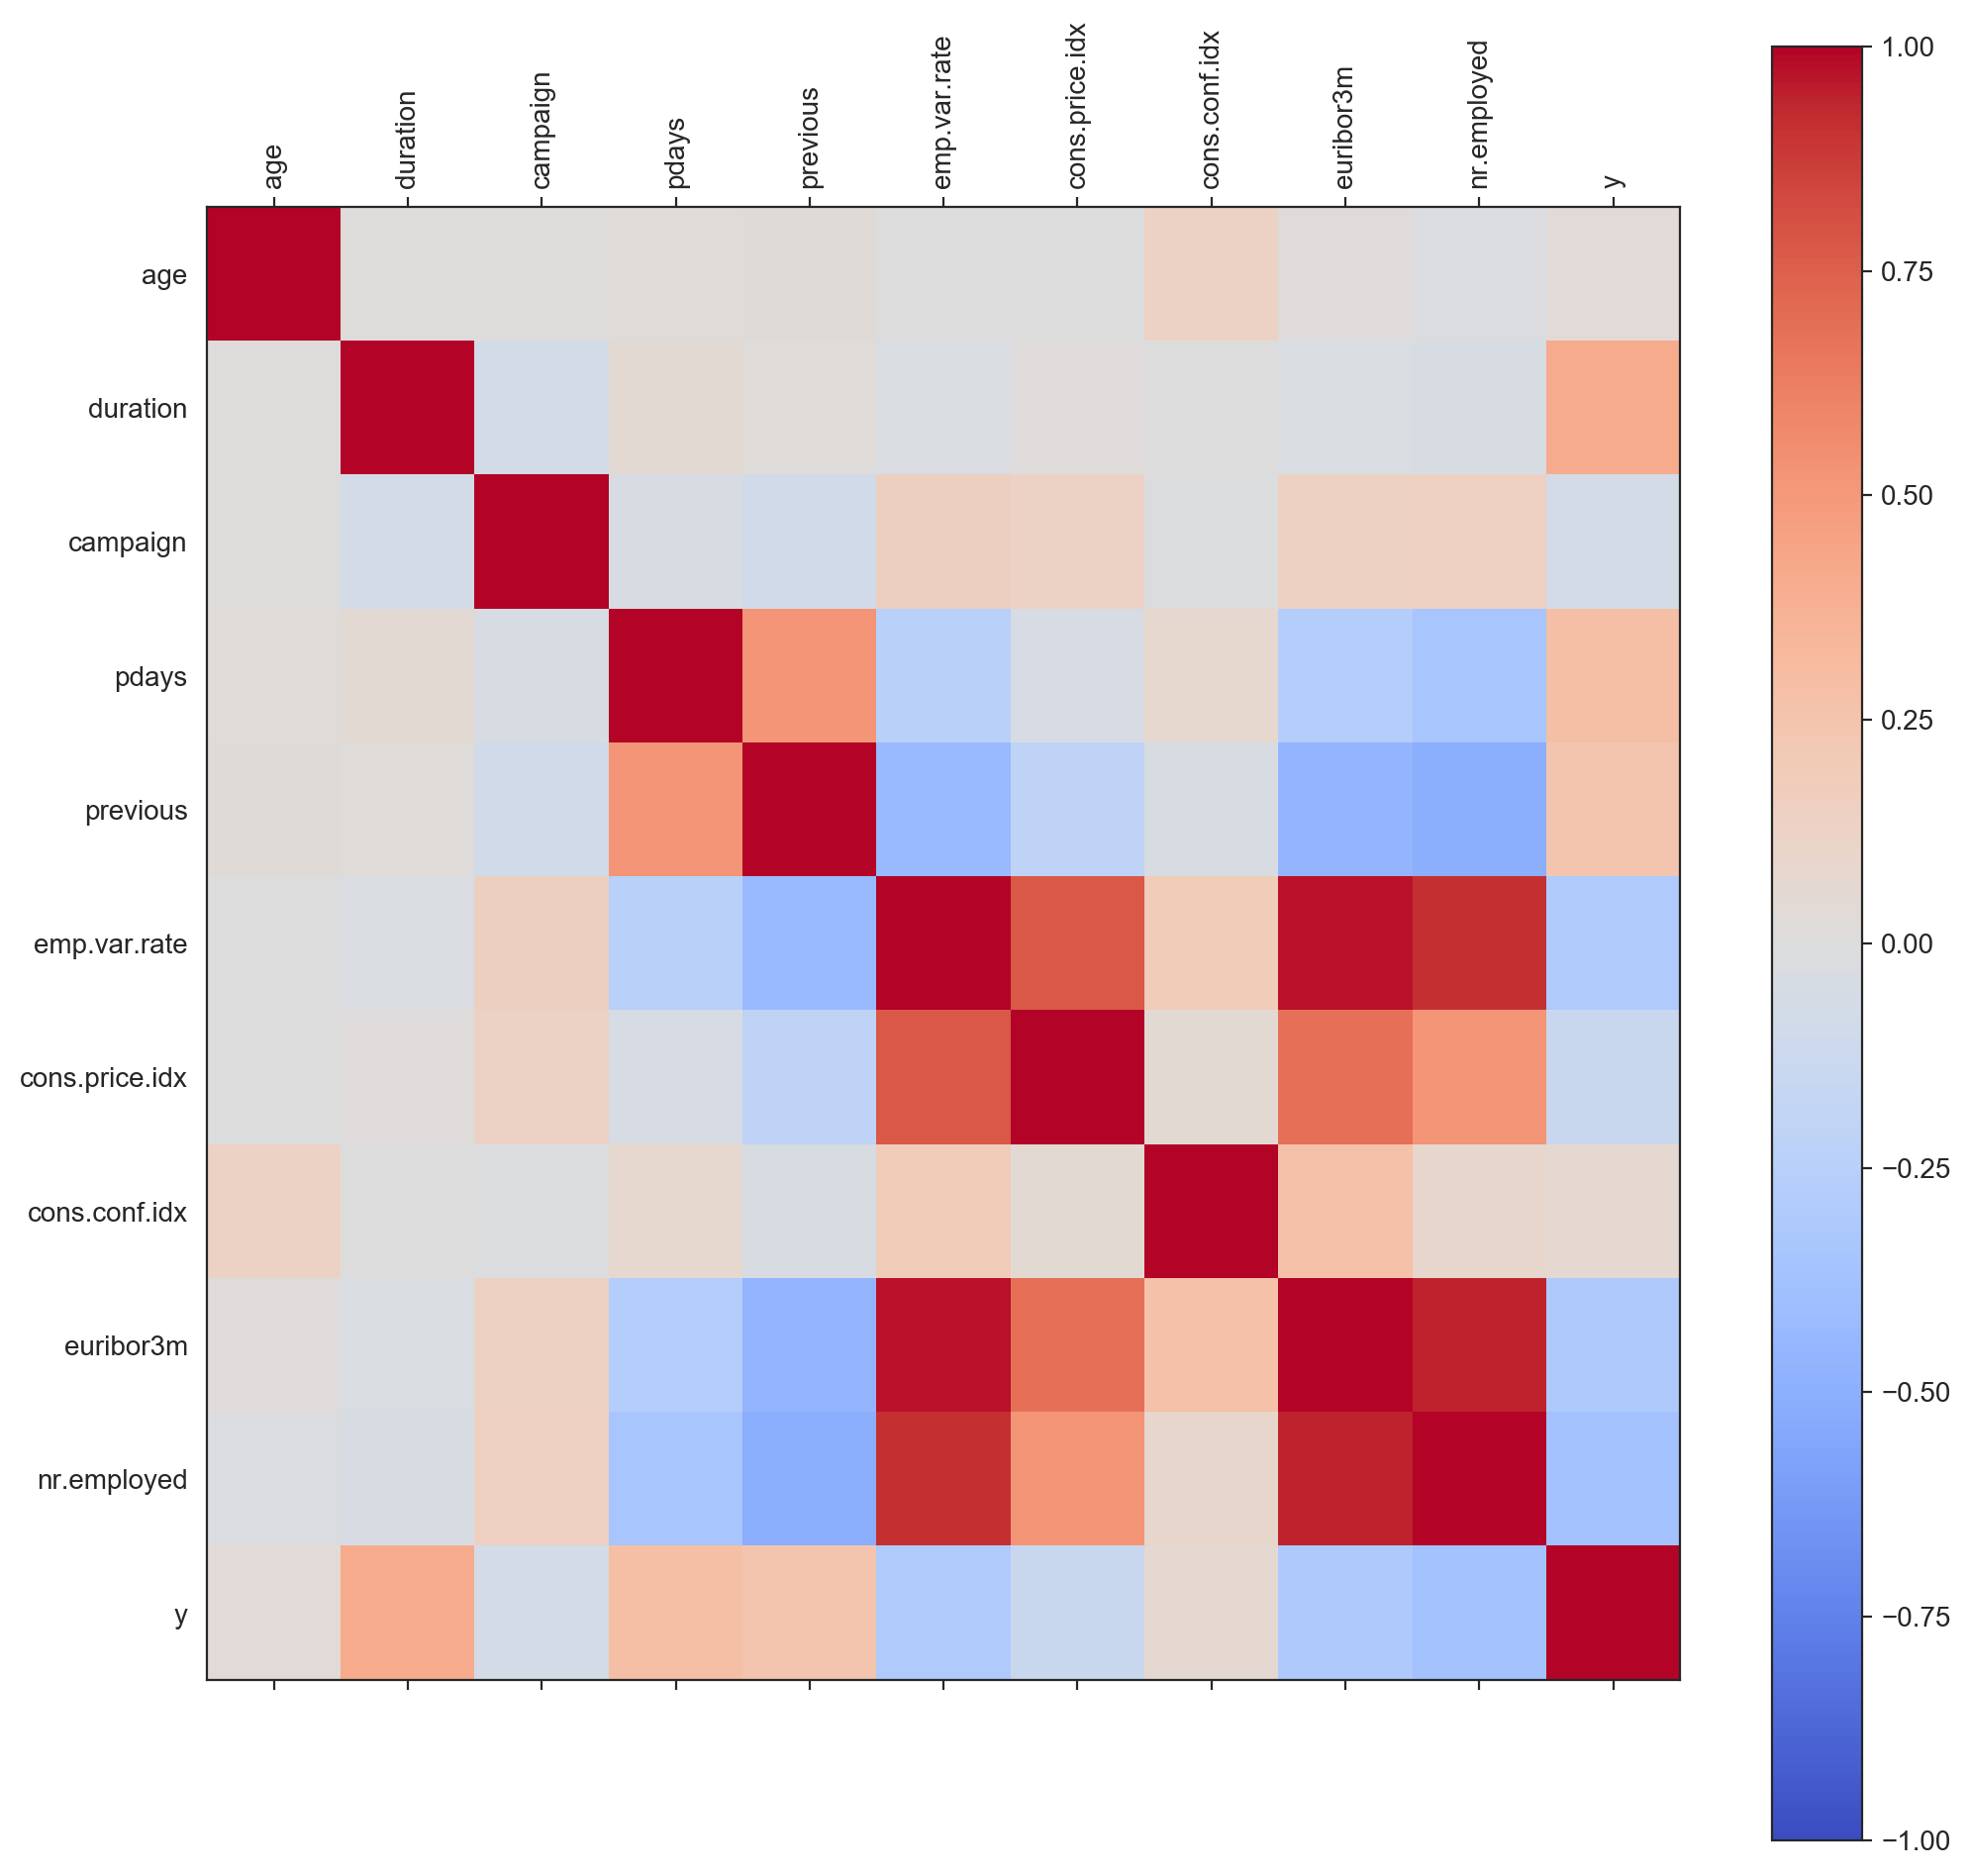

In [76]:
corr_heatmap_plot(train_df, cmap='coolwarm')

The correlation between some of the features is very high. Age is particularly not very correlated with other variables.

## <a id='37'>Duplicate values</a>  

Let's now check how many duplicate values exists per columns.

In [77]:
%%time
unique_max_train = []
unique_max_test = []
for feature in numer_feat:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

Wall time: 13.9 ms


Let's show the top 15 max of duplicate values per train set.

In [78]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

3         4         2             5            9  \
Feature         pdays  previous  campaign  emp.var.rate  nr.employed   
Max duplicates  31704     28422     14136         12977        12977   
Value              -1         0         1           1.4       5228.1   

                             6              7          8     0         1  
Feature         cons.price.idx  cons.conf.idx  euribor3m   age  duration  
Max duplicates            6232           6232       2297  1559       143  
Value                   93.994          -36.4      4.857    31        85

Let's see also the top 15 number of duplicates values per test set.

In [79]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

3         4         2             5            9  \
Feature         pdays  previous  campaign  emp.var.rate  nr.employed   
Max duplicates   7969      7141      3506          3257         3257   
Value              -1         0         1           1.4       5228.1   

                             6              7          8    0         1  
Feature         cons.price.idx  cons.conf.idx  euribor3m  age  duration  
Max duplicates            1531           1531        571  388        41  
Value                   93.994          -36.4      4.857   31       136

Same columns in train and test set have the same or very close number of duplicates of same or very close values. This means that our test sample is of same quality as the training sample.

# <a id='4'>Feature engineering</a>  

Let's calculate for starting few aggregated values for the existing features.

In [80]:
%%time
idx = numer_feat
for dfn in [test_df_total, train_df_total]:
    dfn['sum'] = dfn[idx].sum(axis=1)  
    dfn['min'] = dfn[idx].min(axis=1)
    dfn['max'] = dfn[idx].max(axis=1)
    dfn['mean'] = dfn[idx].mean(axis=1)
    dfn['std'] = dfn[idx].std(axis=1)
    dfn['skew'] = dfn[idx].skew(axis=1)
    dfn['kurt'] = dfn[idx].kurtosis(axis=1)
    dfn['med'] = dfn[idx].median(axis=1)

Wall time: 56 ms


Let's check the new created features for the numeric values.

In [81]:
train_df_total[train_df_total.columns[-8:]].head()

sum        min          max        mean          std      skew  \
5303   5644.550781 -36.400002  5191.000000  564.455078  1629.296143  3.136243   
13826  5509.681152 -42.700001  5228.100098  550.968140  1644.687988  3.152943   
30138  6180.640137 -47.099998  5099.100098  618.064026  1603.202759  2.974046   
14975  5502.676270 -42.700001  5228.100098  550.267639  1644.891357  3.153247   
26413  5370.975586 -42.000000  5195.799805  537.097534  1637.417725  3.158549   

           kurt     med  
5303   9.874394  3.9285  
13826  9.955990  3.1815  
30138  9.017812  3.5000  
14975  9.957438  3.1790  
26413  9.982629  2.5380

In [82]:
test_df_total[test_df_total.columns[-8:]].head()

sum        min          max        mean          std      skew  \
1382   5405.548828 -36.400002  5191.000000  540.554871  1634.602417  3.157928   
13883  5758.681152 -42.700001  5228.100098  575.868103  1640.503784  3.121633   
33743  5258.273926 -46.200001  5099.100098  525.827393  1607.387695  3.158574   
5523   5403.550781 -36.400002  5191.000000  540.355103  1634.761963  3.157292   
40404  5823.531250 -38.299999  4991.600098  582.353149  1566.255737  3.044472   

           kurt     med  
1382   9.979708  4.4275  
13883  9.801357  3.4815  
33743  9.982761  1.1405  
5523   9.976680  3.4285  
40404  9.400020  0.9520

In [83]:
# swap target column to the end
train_df_total = train_df_total.drop(columns=['y'], axis=1)
train_df_total['y'] = train_df['y']
test_df_total = test_df_total.drop(columns=['y'], axis=1)
test_df_total['y'] = test_df['y']

Let's check the distribution of these new, engineered features.  

We plot first the distribution of new features, grouped by value of corresponding `target` values.

<Figure size 432x288 with 0 Axes>

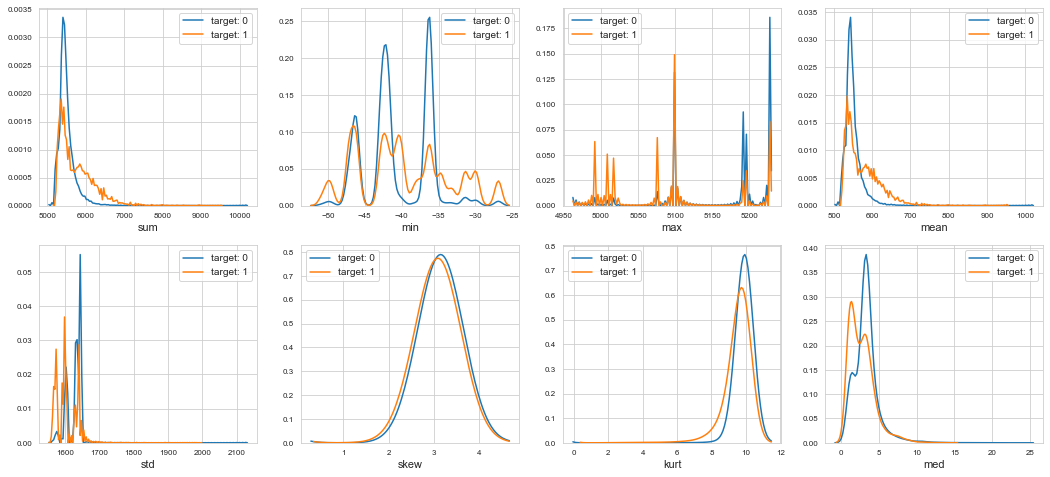

In [84]:
t0 = train_df_total.loc[train_df_total[target] == 0]
t1 = train_df_total.loc[train_df_total[target] == 1]
features = train_df_total.columns[-9:-1] # 8 new features

plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

Let's show the distribution of new features values for train and test.

<Figure size 432x288 with 0 Axes>

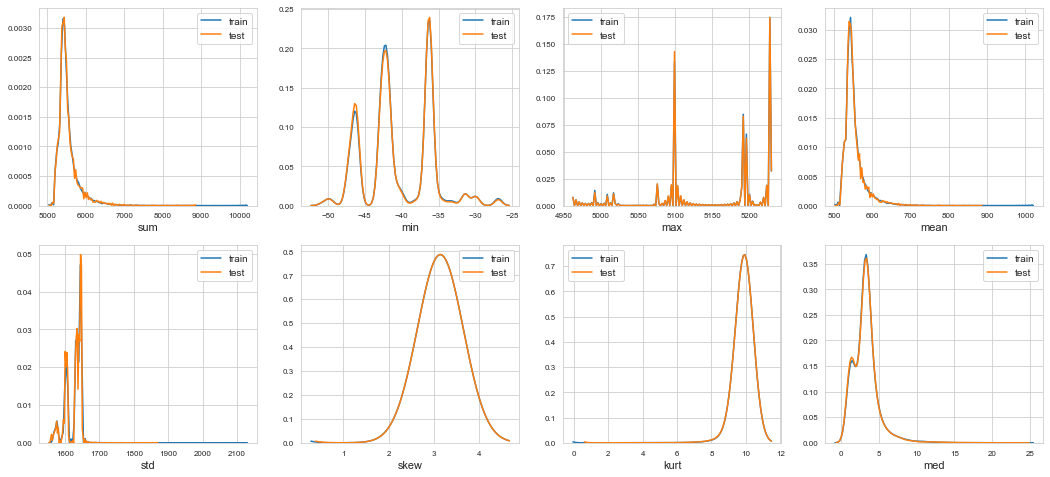

In [85]:
plot_new_feature_distribution(train_df_total, test_df_total, 'train', 'test', features)

We can see that the train_total and test_total have no difference in their distributions of the new features, which is good, while there is a big difference between some of the features between the two classes, like **min**, **sum** and **median**.

Let's check how many features we have now (should be 53 + 8 + 1 target).

In [86]:
print('Train and test columns: {} {}'.format(len(train_df_total.columns), len(test_df_total.columns)))

Train and test columns: 62 62


# <a id='5'>Model</a>  

From the train columns list, we drop the target to form the features list.

In [87]:
features = [c for c in train_df_total.columns if c!=target]
target = train_df_total[target]

We define the hyperparameters for the model.

In [88]:
ratio = len(t0)/len(t1) # ratio between the two imbalanced classes

parameters = {
    'booster': ['gbtree'],
    'max_depth': [3, 5, 7,],
    'min_child_weight': [3, 5, 7],
    'gamma': [0.0, 0.15, 0.3],
    'subsample': [0.5, 1.0],
    'objective': ['binary:logistic'],
    'disable_default_eval_metric': [1],
    'eval_metric': ['auc'],
    'n_estimators': [1000],
    'scale_pos_weight': [ratio],
    'n_jobs': [8]
}

We now run GridSearchCV to identify the best hyperparameters.

In [89]:
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=parameters, cv=10)

In [90]:
%%time
# perform grid search
grid_search.fit(train_df_total[features], target)

Wall time: 2h 33min 7s


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_p...
                         'disable_default_eval_metric': [1],
                         'eval_metric': ['auc'], 'gamma': [0.0, 0.15, 0.3],
                         'max_depth': [3, 5, 7], 'min_child_weight': [3, 5, 7],
                         'n_estimators': [1000], 'n_jobs': [8],
                         'objective'

In [91]:
# get best parameters
best_estimator = grid_search.best_estimator_
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

# replace parameters
#best_parameters['verbosity'] = 1
#best_parameters['verbose_eval'] = 100

print("Best Estimator:", best_estimator)
print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_parameters)
print("Balance Ratio:", round(ratio, 3))

Best Estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=1, eval_metric='auc', gamma=0.15,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.8243170862346005,
              seed=None, silent=None, subsample=0.5, verbosity=0)
Best Accuracy: 0.9074962063732928
Best Parameters: {'booster': 'gbtree', 'disable_default_eval_metric': 1, 'eval_metric': 'auc', 'gamma': 0.15, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 1000, 'n_jobs': 8, 'objective': 'binary:logistic', 'scale_pos_weight': 7.8243170862346005, 'subsample': 0.5, 'verbosity': 0, 'verbose_eval': 100}
Balance Ratio: 7.824


We run the 1st cross-validated model and test the performance on the test set.

## Model 1 - With engineered features

In [92]:
%%time
clf1 = xgb.XGBClassifier(**best_parameters)
tr_val = (train_df_total[features], target)
ts_val = (test_df_total[features], test_df_total['y'])

clf1.fit(train_df_total[features], target, eval_metric='auc', eval_set=[tr_val, ts_val])

[0]	validation_0-auc:0.943033	validation_1-auc:0.931757
[1]	validation_0-auc:0.947304	validation_1-auc:0.934507
[2]	validation_0-auc:0.950168	validation_1-auc:0.936386
[3]	validation_0-auc:0.951532	validation_1-auc:0.937866
[4]	validation_0-auc:0.952819	validation_1-auc:0.939659
[5]	validation_0-auc:0.953941	validation_1-auc:0.939982
[6]	validation_0-auc:0.954973	validation_1-auc:0.940681
[7]	validation_0-auc:0.955155	validation_1-auc:0.941177
[8]	validation_0-auc:0.956056	validation_1-auc:0.942698
[9]	validation_0-auc:0.956704	validation_1-auc:0.943647
[10]	validation_0-auc:0.957483	validation_1-auc:0.943482
[11]	validation_0-auc:0.958116	validation_1-auc:0.943555
[12]	validation_0-auc:0.958502	validation_1-auc:0.943871
[13]	validation_0-auc:0.959032	validation_1-auc:0.943995
[14]	validation_0-auc:0.959517	validation_1-auc:0.944239
[15]	validation_0-auc:0.959986	validation_1-auc:0.944518
[16]	validation_0-auc:0.960691	validation_1-auc:0.944933
[17]	validation_0-auc:0.960889	validation

[144]	validation_0-auc:0.984268	validation_1-auc:0.944288
[145]	validation_0-auc:0.984389	validation_1-auc:0.944263
[146]	validation_0-auc:0.984538	validation_1-auc:0.9442
[147]	validation_0-auc:0.984685	validation_1-auc:0.944216
[148]	validation_0-auc:0.984726	validation_1-auc:0.944199
[149]	validation_0-auc:0.98486	validation_1-auc:0.944214
[150]	validation_0-auc:0.985035	validation_1-auc:0.944163
[151]	validation_0-auc:0.985211	validation_1-auc:0.944242
[152]	validation_0-auc:0.98524	validation_1-auc:0.944177
[153]	validation_0-auc:0.985381	validation_1-auc:0.944152
[154]	validation_0-auc:0.985459	validation_1-auc:0.944089
[155]	validation_0-auc:0.985607	validation_1-auc:0.94398
[156]	validation_0-auc:0.98569	validation_1-auc:0.94401
[157]	validation_0-auc:0.985724	validation_1-auc:0.944009
[158]	validation_0-auc:0.985849	validation_1-auc:0.94398
[159]	validation_0-auc:0.985963	validation_1-auc:0.943863
[160]	validation_0-auc:0.986139	validation_1-auc:0.94376
[161]	validation_0-auc:

[286]	validation_0-auc:0.995148	validation_1-auc:0.942949
[287]	validation_0-auc:0.995136	validation_1-auc:0.943001
[288]	validation_0-auc:0.995183	validation_1-auc:0.943025
[289]	validation_0-auc:0.995211	validation_1-auc:0.943013
[290]	validation_0-auc:0.995257	validation_1-auc:0.943019
[291]	validation_0-auc:0.995307	validation_1-auc:0.942906
[292]	validation_0-auc:0.995353	validation_1-auc:0.942979
[293]	validation_0-auc:0.995426	validation_1-auc:0.942945
[294]	validation_0-auc:0.995445	validation_1-auc:0.942896
[295]	validation_0-auc:0.995482	validation_1-auc:0.94293
[296]	validation_0-auc:0.995515	validation_1-auc:0.942917
[297]	validation_0-auc:0.995525	validation_1-auc:0.942979
[298]	validation_0-auc:0.995581	validation_1-auc:0.942972
[299]	validation_0-auc:0.995615	validation_1-auc:0.943002
[300]	validation_0-auc:0.995677	validation_1-auc:0.943001
[301]	validation_0-auc:0.995697	validation_1-auc:0.942965
[302]	validation_0-auc:0.9957	validation_1-auc:0.942998
[303]	validation_

[428]	validation_0-auc:0.998557	validation_1-auc:0.941649
[429]	validation_0-auc:0.998572	validation_1-auc:0.941621
[430]	validation_0-auc:0.998577	validation_1-auc:0.941622
[431]	validation_0-auc:0.998587	validation_1-auc:0.941587
[432]	validation_0-auc:0.998602	validation_1-auc:0.941542
[433]	validation_0-auc:0.998627	validation_1-auc:0.941492
[434]	validation_0-auc:0.998635	validation_1-auc:0.941463
[435]	validation_0-auc:0.998646	validation_1-auc:0.941478
[436]	validation_0-auc:0.998647	validation_1-auc:0.941482
[437]	validation_0-auc:0.998678	validation_1-auc:0.941493
[438]	validation_0-auc:0.998693	validation_1-auc:0.941478
[439]	validation_0-auc:0.998702	validation_1-auc:0.941409
[440]	validation_0-auc:0.998707	validation_1-auc:0.941476
[441]	validation_0-auc:0.998699	validation_1-auc:0.941472
[442]	validation_0-auc:0.998704	validation_1-auc:0.941413
[443]	validation_0-auc:0.998712	validation_1-auc:0.941374
[444]	validation_0-auc:0.998736	validation_1-auc:0.941275
[445]	validati

[570]	validation_0-auc:0.999622	validation_1-auc:0.939959
[571]	validation_0-auc:0.999625	validation_1-auc:0.939919
[572]	validation_0-auc:0.999624	validation_1-auc:0.939915
[573]	validation_0-auc:0.999628	validation_1-auc:0.93986
[574]	validation_0-auc:0.999637	validation_1-auc:0.939911
[575]	validation_0-auc:0.999642	validation_1-auc:0.939973
[576]	validation_0-auc:0.999642	validation_1-auc:0.940041
[577]	validation_0-auc:0.999645	validation_1-auc:0.939991
[578]	validation_0-auc:0.999647	validation_1-auc:0.939984
[579]	validation_0-auc:0.999652	validation_1-auc:0.939989
[580]	validation_0-auc:0.999652	validation_1-auc:0.939983
[581]	validation_0-auc:0.999658	validation_1-auc:0.939993
[582]	validation_0-auc:0.999664	validation_1-auc:0.940018
[583]	validation_0-auc:0.999669	validation_1-auc:0.940005
[584]	validation_0-auc:0.999673	validation_1-auc:0.940007
[585]	validation_0-auc:0.999675	validation_1-auc:0.939924
[586]	validation_0-auc:0.999683	validation_1-auc:0.939891
[587]	validatio

[712]	validation_0-auc:0.999891	validation_1-auc:0.939098
[713]	validation_0-auc:0.999892	validation_1-auc:0.939085
[714]	validation_0-auc:0.999892	validation_1-auc:0.939016
[715]	validation_0-auc:0.999895	validation_1-auc:0.939003
[716]	validation_0-auc:0.999895	validation_1-auc:0.938966
[717]	validation_0-auc:0.999895	validation_1-auc:0.938899
[718]	validation_0-auc:0.999898	validation_1-auc:0.938818
[719]	validation_0-auc:0.999898	validation_1-auc:0.938851
[720]	validation_0-auc:0.999899	validation_1-auc:0.93888
[721]	validation_0-auc:0.999898	validation_1-auc:0.938844
[722]	validation_0-auc:0.999899	validation_1-auc:0.938818
[723]	validation_0-auc:0.9999	validation_1-auc:0.938839
[724]	validation_0-auc:0.9999	validation_1-auc:0.938819
[725]	validation_0-auc:0.999899	validation_1-auc:0.938793
[726]	validation_0-auc:0.9999	validation_1-auc:0.938708
[727]	validation_0-auc:0.999901	validation_1-auc:0.938691
[728]	validation_0-auc:0.999902	validation_1-auc:0.938726
[729]	validation_0-au

[854]	validation_0-auc:0.999978	validation_1-auc:0.937929
[855]	validation_0-auc:0.999978	validation_1-auc:0.937974
[856]	validation_0-auc:0.999978	validation_1-auc:0.938004
[857]	validation_0-auc:0.999978	validation_1-auc:0.938007
[858]	validation_0-auc:0.99998	validation_1-auc:0.938018
[859]	validation_0-auc:0.99998	validation_1-auc:0.938006
[860]	validation_0-auc:0.99998	validation_1-auc:0.93797
[861]	validation_0-auc:0.99998	validation_1-auc:0.938
[862]	validation_0-auc:0.999981	validation_1-auc:0.938002
[863]	validation_0-auc:0.999981	validation_1-auc:0.938042
[864]	validation_0-auc:0.999981	validation_1-auc:0.938053
[865]	validation_0-auc:0.999981	validation_1-auc:0.937986
[866]	validation_0-auc:0.999982	validation_1-auc:0.937976
[867]	validation_0-auc:0.999982	validation_1-auc:0.937945
[868]	validation_0-auc:0.999982	validation_1-auc:0.937953
[869]	validation_0-auc:0.999982	validation_1-auc:0.937993
[870]	validation_0-auc:0.999982	validation_1-auc:0.937979
[871]	validation_0-auc

[996]	validation_0-auc:0.999998	validation_1-auc:0.937438
[997]	validation_0-auc:0.999998	validation_1-auc:0.937442
[998]	validation_0-auc:0.999998	validation_1-auc:0.937561
[999]	validation_0-auc:0.999998	validation_1-auc:0.937556
Wall time: 33.9 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=1, eval_metric='auc', gamma=0.15,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.8243170862346005,
              seed=None, silent=None, subsample=0.5, verbose_eval=100,
              verbosity=0)

In [93]:
true_flag = test_df_total['y']
pred_flag = clf1.predict(test_df_total[features])

print("AUC score: {:<8.3f}".format(roc_auc_score(true_flag, pred_flag)))

AUC score: 0.806   


Check confusion matrix, AUC plot and other metrics

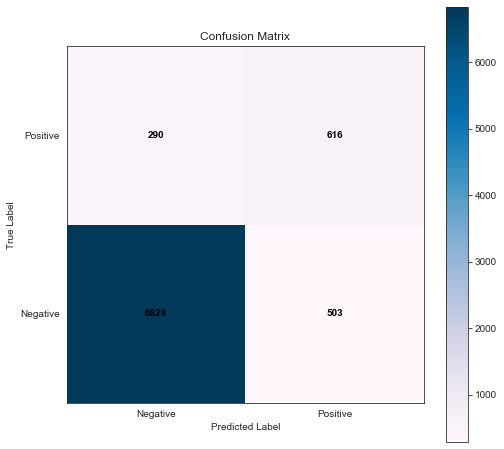

accuracy: 90.37 %
precision: 55.05 %
Recall: 67.99 %
specificity: 93.14 %
F-score: 60.84 %


In [94]:
metrics = confusion_mat_plot(true_flag, pred_flag)

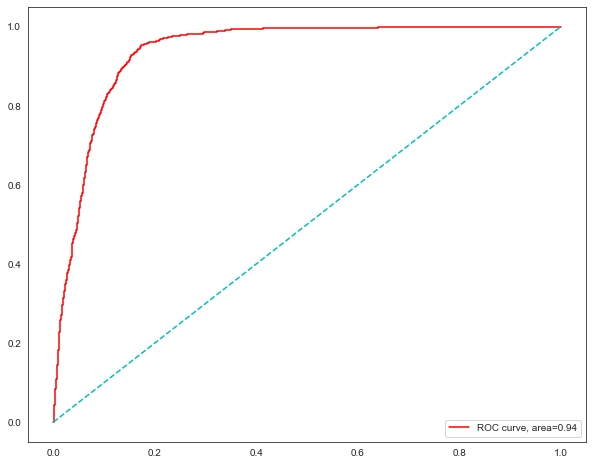

gini 87.511 %


In [95]:
gini = auc_plot(test_df_total[features], true_flag, clf1)

# record metrics
model_comparison = pd.DataFrame()

model_comparison['With Eng Feat'] = [gini, metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]]
model_comparison.index = ['Gini', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'F-Score']

Let's check the feature importance.

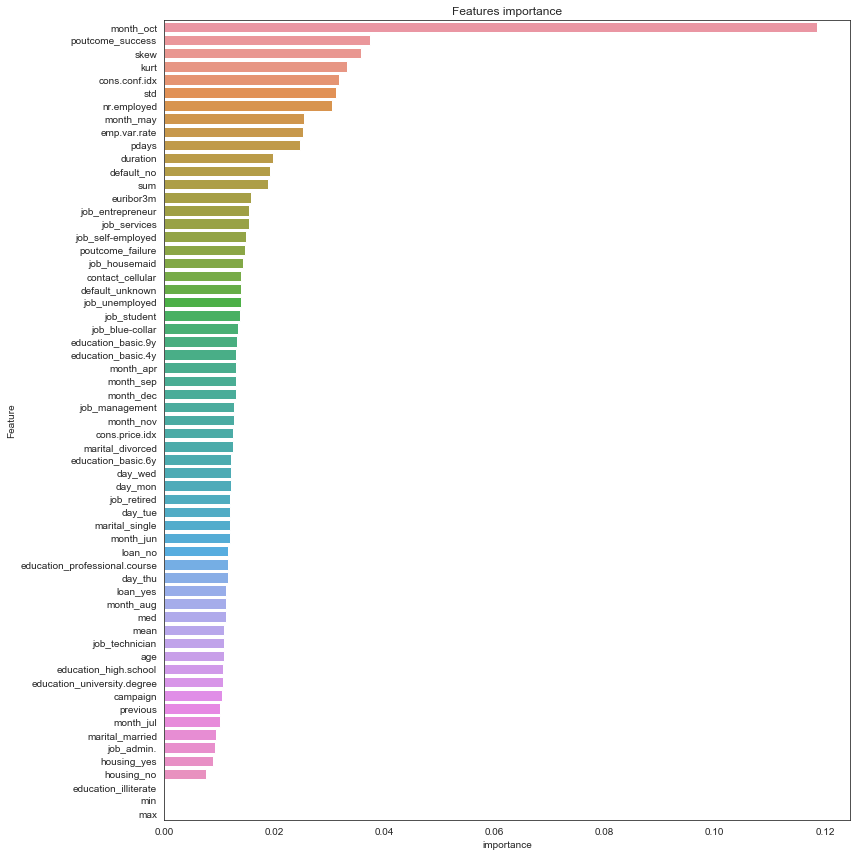

In [96]:
feature_importance_df = pd.DataFrame()
feature_importance_df["Feature"] = features
feature_importance_df["importance"] = clf1.feature_importances_

# plot results
plt.figure(figsize=(12,12))
sns.barplot(x="importance", y="Feature", data=feature_importance_df.sort_values(by="importance",ascending=False))
plt.title('Features importance')
plt.tight_layout()
plt.show()

It seems that most of the features that we engineered are the most important ones to decide the split.

So, as for the next steps, we will build three models, with the same hyperparameters for training and compare the performance:

* One with the __top 5 features from the previous model__

* We will try to make our model more explainable, and check if we sacrifice in performance. This means that we will try the same model for __dataset that does not contain the engineered features__ and check performance

* Next we will also choose the __top 5 features from that model__ too

## Model 2 - Top 5 features

In [97]:
%%time
clf2 = xgb.XGBClassifier(**best_parameters)
top_5_feat = feature_importance_df.sort_values(by="importance",ascending=False)['Feature'].values[:5]
tr_val = (train_df_total[top_5_feat], target)
ts_val = (test_df_total[top_5_feat], test_df_total['y'])

clf2.fit(train_df_total[top_5_feat], target, eval_metric='auc', eval_set=[tr_val, ts_val])

[0]	validation_0-auc:0.932246	validation_1-auc:0.926305
[1]	validation_0-auc:0.936538	validation_1-auc:0.930017
[2]	validation_0-auc:0.936971	validation_1-auc:0.929717
[3]	validation_0-auc:0.938608	validation_1-auc:0.932285
[4]	validation_0-auc:0.942368	validation_1-auc:0.937251
[5]	validation_0-auc:0.94405	validation_1-auc:0.938275
[6]	validation_0-auc:0.945183	validation_1-auc:0.938988
[7]	validation_0-auc:0.945584	validation_1-auc:0.939349
[8]	validation_0-auc:0.945868	validation_1-auc:0.939238
[9]	validation_0-auc:0.946375	validation_1-auc:0.939687
[10]	validation_0-auc:0.946521	validation_1-auc:0.939771
[11]	validation_0-auc:0.946923	validation_1-auc:0.939901
[12]	validation_0-auc:0.947251	validation_1-auc:0.940129
[13]	validation_0-auc:0.947483	validation_1-auc:0.94021
[14]	validation_0-auc:0.947632	validation_1-auc:0.939982
[15]	validation_0-auc:0.947797	validation_1-auc:0.940019
[16]	validation_0-auc:0.947983	validation_1-auc:0.940331
[17]	validation_0-auc:0.948189	validation_1

[144]	validation_0-auc:0.962171	validation_1-auc:0.93841
[145]	validation_0-auc:0.962226	validation_1-auc:0.938328
[146]	validation_0-auc:0.962283	validation_1-auc:0.938369
[147]	validation_0-auc:0.962347	validation_1-auc:0.938411
[148]	validation_0-auc:0.962446	validation_1-auc:0.938351
[149]	validation_0-auc:0.962455	validation_1-auc:0.938356
[150]	validation_0-auc:0.962574	validation_1-auc:0.93838
[151]	validation_0-auc:0.962635	validation_1-auc:0.93837
[152]	validation_0-auc:0.962684	validation_1-auc:0.938433
[153]	validation_0-auc:0.962816	validation_1-auc:0.938325
[154]	validation_0-auc:0.962887	validation_1-auc:0.9384
[155]	validation_0-auc:0.962979	validation_1-auc:0.938411
[156]	validation_0-auc:0.96301	validation_1-auc:0.938368
[157]	validation_0-auc:0.963087	validation_1-auc:0.938329
[158]	validation_0-auc:0.963227	validation_1-auc:0.938216
[159]	validation_0-auc:0.963288	validation_1-auc:0.938309
[160]	validation_0-auc:0.963407	validation_1-auc:0.938275
[161]	validation_0-a

[286]	validation_0-auc:0.971525	validation_1-auc:0.934652
[287]	validation_0-auc:0.971576	validation_1-auc:0.93474
[288]	validation_0-auc:0.971642	validation_1-auc:0.934686
[289]	validation_0-auc:0.971681	validation_1-auc:0.934649
[290]	validation_0-auc:0.971765	validation_1-auc:0.934643
[291]	validation_0-auc:0.971872	validation_1-auc:0.934613
[292]	validation_0-auc:0.971893	validation_1-auc:0.934719
[293]	validation_0-auc:0.971954	validation_1-auc:0.934668
[294]	validation_0-auc:0.972018	validation_1-auc:0.934658
[295]	validation_0-auc:0.972042	validation_1-auc:0.934575
[296]	validation_0-auc:0.972136	validation_1-auc:0.934617
[297]	validation_0-auc:0.972176	validation_1-auc:0.934596
[298]	validation_0-auc:0.97221	validation_1-auc:0.934581
[299]	validation_0-auc:0.972238	validation_1-auc:0.934556
[300]	validation_0-auc:0.972325	validation_1-auc:0.934516
[301]	validation_0-auc:0.972317	validation_1-auc:0.934512
[302]	validation_0-auc:0.972368	validation_1-auc:0.934438
[303]	validation

[428]	validation_0-auc:0.977505	validation_1-auc:0.933199
[429]	validation_0-auc:0.977521	validation_1-auc:0.933131
[430]	validation_0-auc:0.977554	validation_1-auc:0.933059
[431]	validation_0-auc:0.977555	validation_1-auc:0.933125
[432]	validation_0-auc:0.977579	validation_1-auc:0.933177
[433]	validation_0-auc:0.977586	validation_1-auc:0.933244
[434]	validation_0-auc:0.977667	validation_1-auc:0.933102
[435]	validation_0-auc:0.977702	validation_1-auc:0.933158
[436]	validation_0-auc:0.97772	validation_1-auc:0.93318
[437]	validation_0-auc:0.977748	validation_1-auc:0.933169
[438]	validation_0-auc:0.977754	validation_1-auc:0.933125
[439]	validation_0-auc:0.977776	validation_1-auc:0.933159
[440]	validation_0-auc:0.977851	validation_1-auc:0.933112
[441]	validation_0-auc:0.977838	validation_1-auc:0.933027
[442]	validation_0-auc:0.97789	validation_1-auc:0.933016
[443]	validation_0-auc:0.97793	validation_1-auc:0.932985
[444]	validation_0-auc:0.977934	validation_1-auc:0.932981
[445]	validation_0

[570]	validation_0-auc:0.98195	validation_1-auc:0.932098
[571]	validation_0-auc:0.982019	validation_1-auc:0.932076
[572]	validation_0-auc:0.982013	validation_1-auc:0.932054
[573]	validation_0-auc:0.982074	validation_1-auc:0.93202
[574]	validation_0-auc:0.982105	validation_1-auc:0.932028
[575]	validation_0-auc:0.982093	validation_1-auc:0.932043
[576]	validation_0-auc:0.982118	validation_1-auc:0.932021
[577]	validation_0-auc:0.982122	validation_1-auc:0.932101
[578]	validation_0-auc:0.982149	validation_1-auc:0.932069
[579]	validation_0-auc:0.982212	validation_1-auc:0.932021
[580]	validation_0-auc:0.982223	validation_1-auc:0.932011
[581]	validation_0-auc:0.982294	validation_1-auc:0.932057
[582]	validation_0-auc:0.98231	validation_1-auc:0.932068
[583]	validation_0-auc:0.982332	validation_1-auc:0.932116
[584]	validation_0-auc:0.982381	validation_1-auc:0.932018
[585]	validation_0-auc:0.982406	validation_1-auc:0.931955
[586]	validation_0-auc:0.982455	validation_1-auc:0.93206
[587]	validation_0

[712]	validation_0-auc:0.985564	validation_1-auc:0.930785
[713]	validation_0-auc:0.985575	validation_1-auc:0.930798
[714]	validation_0-auc:0.985641	validation_1-auc:0.93079
[715]	validation_0-auc:0.98571	validation_1-auc:0.93078
[716]	validation_0-auc:0.985752	validation_1-auc:0.930762
[717]	validation_0-auc:0.985753	validation_1-auc:0.930725
[718]	validation_0-auc:0.985786	validation_1-auc:0.930691
[719]	validation_0-auc:0.985802	validation_1-auc:0.930704
[720]	validation_0-auc:0.985785	validation_1-auc:0.930775
[721]	validation_0-auc:0.9858	validation_1-auc:0.930789
[722]	validation_0-auc:0.985827	validation_1-auc:0.930863
[723]	validation_0-auc:0.985858	validation_1-auc:0.930885
[724]	validation_0-auc:0.985901	validation_1-auc:0.93085
[725]	validation_0-auc:0.985901	validation_1-auc:0.930888
[726]	validation_0-auc:0.985961	validation_1-auc:0.930914
[727]	validation_0-auc:0.985999	validation_1-auc:0.930983
[728]	validation_0-auc:0.986015	validation_1-auc:0.930983
[729]	validation_0-a

[854]	validation_0-auc:0.988356	validation_1-auc:0.929789
[855]	validation_0-auc:0.988365	validation_1-auc:0.929823
[856]	validation_0-auc:0.98835	validation_1-auc:0.92984
[857]	validation_0-auc:0.988366	validation_1-auc:0.929878
[858]	validation_0-auc:0.988382	validation_1-auc:0.929903
[859]	validation_0-auc:0.988388	validation_1-auc:0.929855
[860]	validation_0-auc:0.988439	validation_1-auc:0.929775
[861]	validation_0-auc:0.988442	validation_1-auc:0.929786
[862]	validation_0-auc:0.988463	validation_1-auc:0.92966
[863]	validation_0-auc:0.988508	validation_1-auc:0.929693
[864]	validation_0-auc:0.988524	validation_1-auc:0.929727
[865]	validation_0-auc:0.98853	validation_1-auc:0.929732
[866]	validation_0-auc:0.988582	validation_1-auc:0.929704
[867]	validation_0-auc:0.988621	validation_1-auc:0.929665
[868]	validation_0-auc:0.988611	validation_1-auc:0.929705
[869]	validation_0-auc:0.988578	validation_1-auc:0.929724
[870]	validation_0-auc:0.98858	validation_1-auc:0.929689
[871]	validation_0-

[996]	validation_0-auc:0.990474	validation_1-auc:0.928641
[997]	validation_0-auc:0.990503	validation_1-auc:0.928528
[998]	validation_0-auc:0.990515	validation_1-auc:0.928467
[999]	validation_0-auc:0.990556	validation_1-auc:0.928361
Wall time: 14 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=1, eval_metric='auc', gamma=0.15,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.8243170862346005,
              seed=None, silent=None, subsample=0.5, verbose_eval=100,
              verbosity=0)

In [98]:
true_flag = test_df_total['y']
pred_flag = clf2.predict(test_df_total[top_5_feat])

print("AUC score: {:<8.3f}".format(roc_auc_score(true_flag, pred_flag)))

AUC score: 0.830   


Check confusion matrix, AUC plot and other metrics

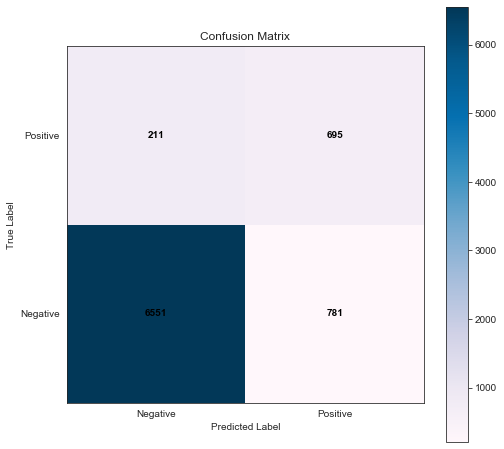

accuracy: 87.96 %
precision: 47.09 %
Recall: 76.71 %
specificity: 89.35 %
F-score: 58.35 %


In [99]:
metrics = confusion_mat_plot(true_flag, pred_flag)

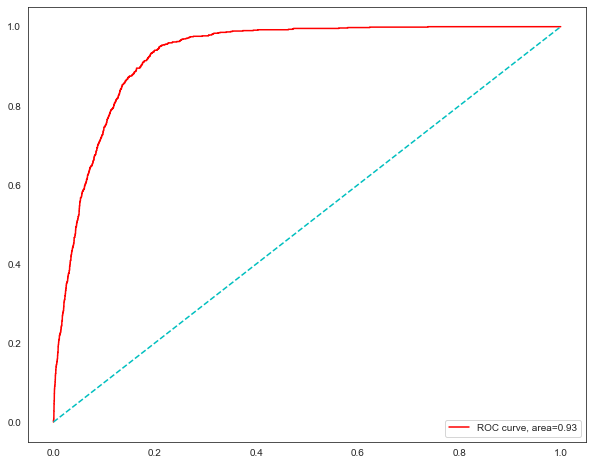

gini 85.672 %


In [100]:
gini = auc_plot(test_df_total[top_5_feat], true_flag, clf2)

# record new metrics
model_comparison['With Eng Feat-Top 5'] = [gini, metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]]

Here we can clearly see that we are losing in performance by a little in our simplified model, but we are having a less complicated model.

Let's check again the potential changes in feature importance (with engineered features).

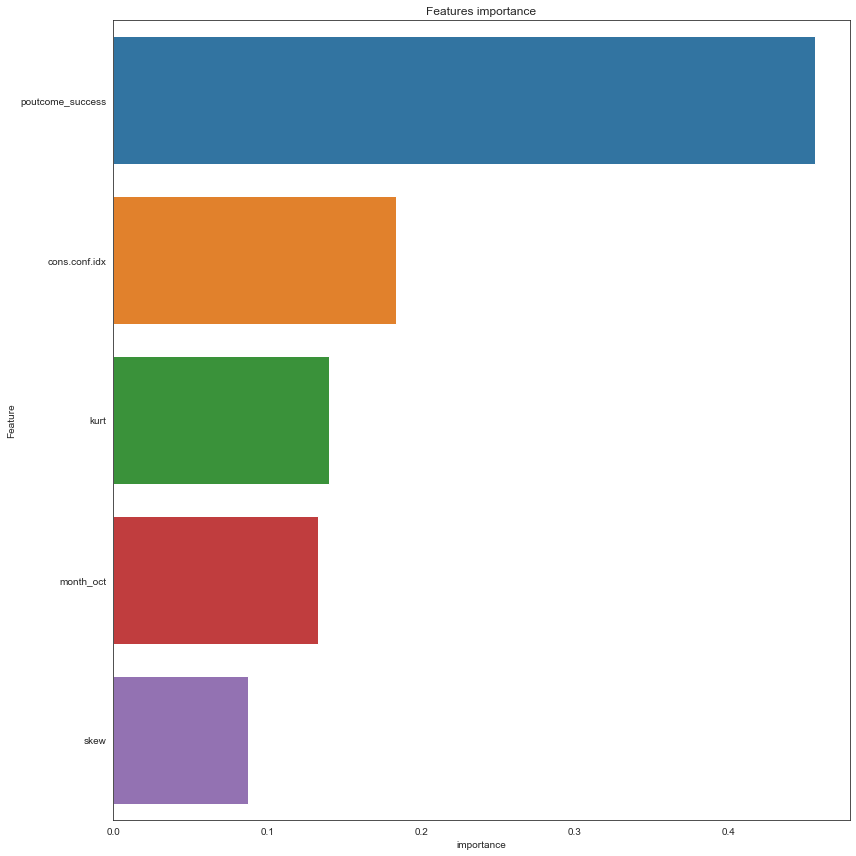

In [101]:
feature_importance_df2 = pd.DataFrame()
feature_importance_df2["Feature"] = top_5_feat
feature_importance_df2["importance"] = clf2.feature_importances_

# plot results
plt.figure(figsize=(12,12))
sns.barplot(x="importance", y="Feature", data=feature_importance_df2.sort_values(by="importance",ascending=False))
plt.title('Features importance')
plt.tight_layout()
plt.show()

We will now try to use only the original processed data, without the engineered features.

## Model 3 - No engineered features

In [102]:
%%time
clf3 = xgb.XGBClassifier(**best_parameters)
tr_val = (train_df_total[train_df_total.columns[:-9]], target)
ts_val = (test_df_total[train_df_total.columns[:-9]], test_df_total['y'])

clf3.fit(train_df_total[train_df_total.columns[:-9]], target, eval_metric='auc', eval_set=[tr_val, ts_val])

[0]	validation_0-auc:0.943149	validation_1-auc:0.933155
[1]	validation_0-auc:0.949653	validation_1-auc:0.938549
[2]	validation_0-auc:0.951773	validation_1-auc:0.940949
[3]	validation_0-auc:0.952958	validation_1-auc:0.94173
[4]	validation_0-auc:0.954174	validation_1-auc:0.942741
[5]	validation_0-auc:0.955023	validation_1-auc:0.943218
[6]	validation_0-auc:0.955586	validation_1-auc:0.943614
[7]	validation_0-auc:0.956291	validation_1-auc:0.943741
[8]	validation_0-auc:0.956568	validation_1-auc:0.94401
[9]	validation_0-auc:0.95712	validation_1-auc:0.944055
[10]	validation_0-auc:0.957835	validation_1-auc:0.944332
[11]	validation_0-auc:0.958249	validation_1-auc:0.944745
[12]	validation_0-auc:0.958522	validation_1-auc:0.944726
[13]	validation_0-auc:0.958976	validation_1-auc:0.94432
[14]	validation_0-auc:0.959321	validation_1-auc:0.94428
[15]	validation_0-auc:0.959604	validation_1-auc:0.944465
[16]	validation_0-auc:0.959926	validation_1-auc:0.944553
[17]	validation_0-auc:0.96005	validation_1-auc

[144]	validation_0-auc:0.98319	validation_1-auc:0.944339
[145]	validation_0-auc:0.983314	validation_1-auc:0.944156
[146]	validation_0-auc:0.983413	validation_1-auc:0.944119
[147]	validation_0-auc:0.983532	validation_1-auc:0.944137
[148]	validation_0-auc:0.983623	validation_1-auc:0.944151
[149]	validation_0-auc:0.98363	validation_1-auc:0.944273
[150]	validation_0-auc:0.983801	validation_1-auc:0.944172
[151]	validation_0-auc:0.983838	validation_1-auc:0.944292
[152]	validation_0-auc:0.983936	validation_1-auc:0.944235
[153]	validation_0-auc:0.984066	validation_1-auc:0.944235
[154]	validation_0-auc:0.984084	validation_1-auc:0.944201
[155]	validation_0-auc:0.984208	validation_1-auc:0.944183
[156]	validation_0-auc:0.984309	validation_1-auc:0.944135
[157]	validation_0-auc:0.98443	validation_1-auc:0.944165
[158]	validation_0-auc:0.984572	validation_1-auc:0.944153
[159]	validation_0-auc:0.984659	validation_1-auc:0.944071
[160]	validation_0-auc:0.984728	validation_1-auc:0.943933
[161]	validation_

[286]	validation_0-auc:0.993705	validation_1-auc:0.94166
[287]	validation_0-auc:0.993736	validation_1-auc:0.941587
[288]	validation_0-auc:0.993779	validation_1-auc:0.941712
[289]	validation_0-auc:0.993809	validation_1-auc:0.94177
[290]	validation_0-auc:0.993819	validation_1-auc:0.94183
[291]	validation_0-auc:0.993928	validation_1-auc:0.941818
[292]	validation_0-auc:0.993975	validation_1-auc:0.941736
[293]	validation_0-auc:0.994029	validation_1-auc:0.941688
[294]	validation_0-auc:0.994057	validation_1-auc:0.941635
[295]	validation_0-auc:0.994109	validation_1-auc:0.941615
[296]	validation_0-auc:0.994157	validation_1-auc:0.941614
[297]	validation_0-auc:0.994186	validation_1-auc:0.941568
[298]	validation_0-auc:0.994203	validation_1-auc:0.941587
[299]	validation_0-auc:0.994247	validation_1-auc:0.941524
[300]	validation_0-auc:0.994311	validation_1-auc:0.941443
[301]	validation_0-auc:0.994394	validation_1-auc:0.941454
[302]	validation_0-auc:0.99441	validation_1-auc:0.941537
[303]	validation_0

[428]	validation_0-auc:0.997831	validation_1-auc:0.939732
[429]	validation_0-auc:0.99784	validation_1-auc:0.939733
[430]	validation_0-auc:0.997859	validation_1-auc:0.939815
[431]	validation_0-auc:0.99787	validation_1-auc:0.939768
[432]	validation_0-auc:0.99788	validation_1-auc:0.939842
[433]	validation_0-auc:0.997904	validation_1-auc:0.939849
[434]	validation_0-auc:0.997916	validation_1-auc:0.939812
[435]	validation_0-auc:0.997911	validation_1-auc:0.939824
[436]	validation_0-auc:0.99792	validation_1-auc:0.93981
[437]	validation_0-auc:0.99793	validation_1-auc:0.939848
[438]	validation_0-auc:0.997925	validation_1-auc:0.93987
[439]	validation_0-auc:0.997943	validation_1-auc:0.939811
[440]	validation_0-auc:0.99796	validation_1-auc:0.939704
[441]	validation_0-auc:0.997958	validation_1-auc:0.939801
[442]	validation_0-auc:0.997994	validation_1-auc:0.939762
[443]	validation_0-auc:0.998009	validation_1-auc:0.93971
[444]	validation_0-auc:0.998033	validation_1-auc:0.939732
[445]	validation_0-auc:

[570]	validation_0-auc:0.999247	validation_1-auc:0.938993
[571]	validation_0-auc:0.99925	validation_1-auc:0.939049
[572]	validation_0-auc:0.999259	validation_1-auc:0.939071
[573]	validation_0-auc:0.999263	validation_1-auc:0.939028
[574]	validation_0-auc:0.999265	validation_1-auc:0.938972
[575]	validation_0-auc:0.999269	validation_1-auc:0.93894
[576]	validation_0-auc:0.999266	validation_1-auc:0.938935
[577]	validation_0-auc:0.999273	validation_1-auc:0.938932
[578]	validation_0-auc:0.999283	validation_1-auc:0.938916
[579]	validation_0-auc:0.999291	validation_1-auc:0.938797
[580]	validation_0-auc:0.999296	validation_1-auc:0.938828
[581]	validation_0-auc:0.999296	validation_1-auc:0.938821
[582]	validation_0-auc:0.999301	validation_1-auc:0.93886
[583]	validation_0-auc:0.999308	validation_1-auc:0.938783
[584]	validation_0-auc:0.99931	validation_1-auc:0.938713
[585]	validation_0-auc:0.999322	validation_1-auc:0.938764
[586]	validation_0-auc:0.999335	validation_1-auc:0.938765
[587]	validation_0

[712]	validation_0-auc:0.999756	validation_1-auc:0.938475
[713]	validation_0-auc:0.999763	validation_1-auc:0.938447
[714]	validation_0-auc:0.999769	validation_1-auc:0.938423
[715]	validation_0-auc:0.999772	validation_1-auc:0.938389
[716]	validation_0-auc:0.999774	validation_1-auc:0.938361
[717]	validation_0-auc:0.99978	validation_1-auc:0.938336
[718]	validation_0-auc:0.999781	validation_1-auc:0.938294
[719]	validation_0-auc:0.999781	validation_1-auc:0.938274
[720]	validation_0-auc:0.999778	validation_1-auc:0.93826
[721]	validation_0-auc:0.999777	validation_1-auc:0.938227
[722]	validation_0-auc:0.999783	validation_1-auc:0.938164
[723]	validation_0-auc:0.999787	validation_1-auc:0.938241
[724]	validation_0-auc:0.999787	validation_1-auc:0.938229
[725]	validation_0-auc:0.999788	validation_1-auc:0.938166
[726]	validation_0-auc:0.999789	validation_1-auc:0.938109
[727]	validation_0-auc:0.999791	validation_1-auc:0.938028
[728]	validation_0-auc:0.999792	validation_1-auc:0.938005
[729]	validation

[854]	validation_0-auc:0.999944	validation_1-auc:0.937346
[855]	validation_0-auc:0.999944	validation_1-auc:0.937316
[856]	validation_0-auc:0.999944	validation_1-auc:0.937294
[857]	validation_0-auc:0.999944	validation_1-auc:0.937233
[858]	validation_0-auc:0.999945	validation_1-auc:0.93723
[859]	validation_0-auc:0.999947	validation_1-auc:0.937262
[860]	validation_0-auc:0.999948	validation_1-auc:0.937243
[861]	validation_0-auc:0.999949	validation_1-auc:0.937226
[862]	validation_0-auc:0.99995	validation_1-auc:0.937275
[863]	validation_0-auc:0.999951	validation_1-auc:0.937316
[864]	validation_0-auc:0.999951	validation_1-auc:0.93735
[865]	validation_0-auc:0.999951	validation_1-auc:0.937325
[866]	validation_0-auc:0.99995	validation_1-auc:0.937352
[867]	validation_0-auc:0.99995	validation_1-auc:0.937331
[868]	validation_0-auc:0.999951	validation_1-auc:0.937318
[869]	validation_0-auc:0.999952	validation_1-auc:0.937359
[870]	validation_0-auc:0.999954	validation_1-auc:0.937328
[871]	validation_0-

[996]	validation_0-auc:0.999985	validation_1-auc:0.937058
[997]	validation_0-auc:0.999985	validation_1-auc:0.937005
[998]	validation_0-auc:0.999985	validation_1-auc:0.937091
[999]	validation_0-auc:0.999984	validation_1-auc:0.937047
Wall time: 29.2 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=1, eval_metric='auc', gamma=0.15,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.8243170862346005,
              seed=None, silent=None, subsample=0.5, verbose_eval=100,
              verbosity=0)

In [103]:
true_flag = test_df_total['y']
pred_flag = clf3.predict(test_df_total[train_df_total.columns[:-9]])

print("AUC score: {:<8.3f}".format(roc_auc_score(true_flag, pred_flag)))

AUC score: 0.804   


Check confusion matrix, AUC plot and other metrics

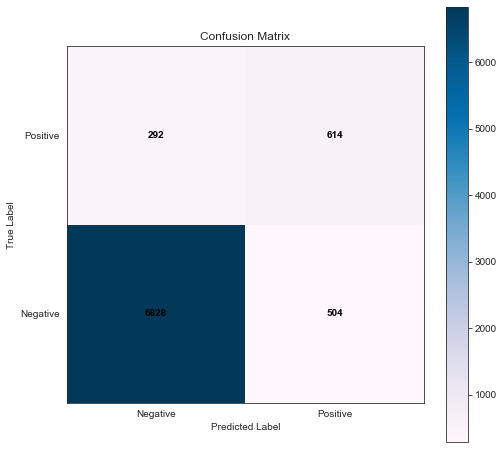

accuracy: 90.34 %
precision: 54.92 %
Recall: 67.77 %
specificity: 93.13 %
F-score: 60.67 %


In [104]:
metrics = confusion_mat_plot(true_flag, pred_flag)

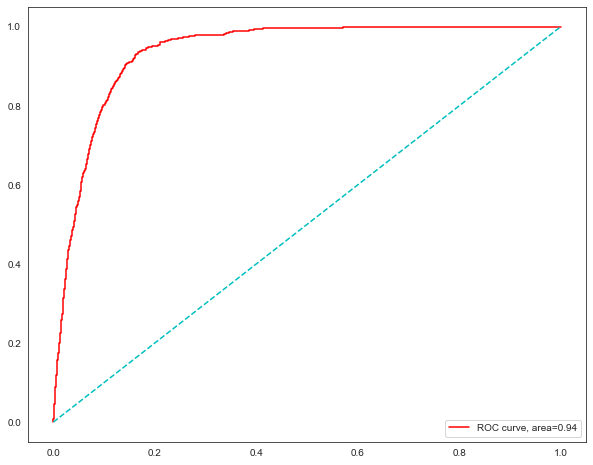

gini 87.409 %


In [105]:
gini = auc_plot(test_df_total[train_df_total.columns[:-9]], true_flag, clf3)

# record new metrics
model_comparison['Without Eng Feat'] = [gini, metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]]

Let's check the new feature importance (without engineered features).

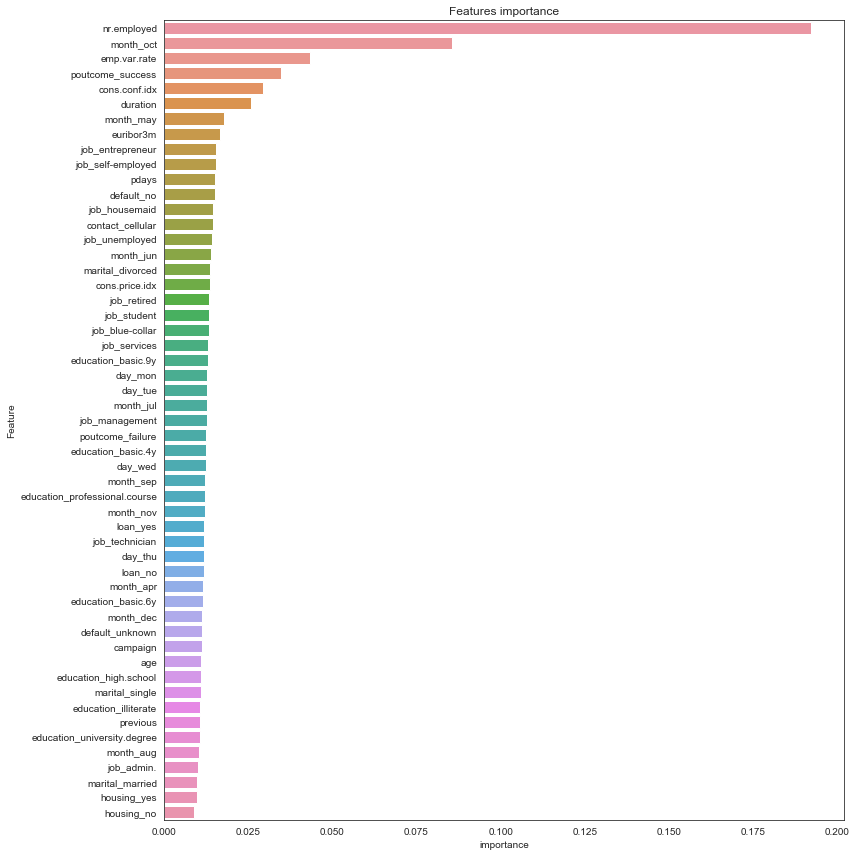

In [106]:
feature_importance_df3 = pd.DataFrame()
feature_importance_df3["Feature"] = train_df_total.columns.to_list()[:-9]
feature_importance_df3["importance"] = clf3.feature_importances_

# plot results
plt.figure(figsize=(12,12))
sns.barplot(x="importance", y="Feature", data=feature_importance_df3.sort_values(by="importance",ascending=False))
plt.title('Features importance')
plt.tight_layout()
plt.show()

## Model 4 - Top 5 features, without the engineered features

In [107]:
%%time
clf4 = xgb.XGBClassifier(**best_parameters)
top_5_feat_2 = feature_importance_df3.sort_values(by="importance",ascending=False)['Feature'].values[:5]
tr_val = (train_df_total[top_5_feat_2], target)
ts_val = (test_df_total[top_5_feat_2], test_df_total['y'])

clf4.fit(train_df_total[top_5_feat_2], target, eval_metric='auc', eval_set=[tr_val, ts_val])

[0]	validation_0-auc:0.791971	validation_1-auc:0.774297
[1]	validation_0-auc:0.7925	validation_1-auc:0.775093
[2]	validation_0-auc:0.792541	validation_1-auc:0.774931
[3]	validation_0-auc:0.792598	validation_1-auc:0.774884
[4]	validation_0-auc:0.792634	validation_1-auc:0.774935
[5]	validation_0-auc:0.792657	validation_1-auc:0.774895
[6]	validation_0-auc:0.792714	validation_1-auc:0.774961
[7]	validation_0-auc:0.792671	validation_1-auc:0.775159
[8]	validation_0-auc:0.792718	validation_1-auc:0.775097
[9]	validation_0-auc:0.79272	validation_1-auc:0.775086
[10]	validation_0-auc:0.792701	validation_1-auc:0.775091
[11]	validation_0-auc:0.792679	validation_1-auc:0.775218
[12]	validation_0-auc:0.792675	validation_1-auc:0.775225
[13]	validation_0-auc:0.792674	validation_1-auc:0.775225
[14]	validation_0-auc:0.792681	validation_1-auc:0.775282
[15]	validation_0-auc:0.792681	validation_1-auc:0.775297
[16]	validation_0-auc:0.792719	validation_1-auc:0.774903
[17]	validation_0-auc:0.792757	validation_1-

[144]	validation_0-auc:0.79279	validation_1-auc:0.774933
[145]	validation_0-auc:0.792794	validation_1-auc:0.775008
[146]	validation_0-auc:0.792797	validation_1-auc:0.774961
[147]	validation_0-auc:0.792797	validation_1-auc:0.77496
[148]	validation_0-auc:0.792798	validation_1-auc:0.775064
[149]	validation_0-auc:0.792794	validation_1-auc:0.775071
[150]	validation_0-auc:0.792786	validation_1-auc:0.775055
[151]	validation_0-auc:0.792786	validation_1-auc:0.775045
[152]	validation_0-auc:0.792779	validation_1-auc:0.775047
[153]	validation_0-auc:0.792785	validation_1-auc:0.774967
[154]	validation_0-auc:0.792789	validation_1-auc:0.774923
[155]	validation_0-auc:0.792782	validation_1-auc:0.774819
[156]	validation_0-auc:0.792787	validation_1-auc:0.774846
[157]	validation_0-auc:0.792782	validation_1-auc:0.774846
[158]	validation_0-auc:0.792782	validation_1-auc:0.774839
[159]	validation_0-auc:0.792781	validation_1-auc:0.774864
[160]	validation_0-auc:0.792783	validation_1-auc:0.774843
[161]	validation

[286]	validation_0-auc:0.792759	validation_1-auc:0.774816
[287]	validation_0-auc:0.792764	validation_1-auc:0.774849
[288]	validation_0-auc:0.792764	validation_1-auc:0.774849
[289]	validation_0-auc:0.792766	validation_1-auc:0.774987
[290]	validation_0-auc:0.792769	validation_1-auc:0.774963
[291]	validation_0-auc:0.792764	validation_1-auc:0.774842
[292]	validation_0-auc:0.792766	validation_1-auc:0.774841
[293]	validation_0-auc:0.792769	validation_1-auc:0.774846
[294]	validation_0-auc:0.792768	validation_1-auc:0.774837
[295]	validation_0-auc:0.792756	validation_1-auc:0.774823
[296]	validation_0-auc:0.792766	validation_1-auc:0.774873
[297]	validation_0-auc:0.792763	validation_1-auc:0.774862
[298]	validation_0-auc:0.792777	validation_1-auc:0.774887
[299]	validation_0-auc:0.792778	validation_1-auc:0.774904
[300]	validation_0-auc:0.792781	validation_1-auc:0.7749
[301]	validation_0-auc:0.792775	validation_1-auc:0.774878
[302]	validation_0-auc:0.79273	validation_1-auc:0.775013
[303]	validation_

[428]	validation_0-auc:0.792741	validation_1-auc:0.775112
[429]	validation_0-auc:0.792776	validation_1-auc:0.774978
[430]	validation_0-auc:0.792778	validation_1-auc:0.774891
[431]	validation_0-auc:0.792773	validation_1-auc:0.774906
[432]	validation_0-auc:0.792785	validation_1-auc:0.774884
[433]	validation_0-auc:0.792778	validation_1-auc:0.775028
[434]	validation_0-auc:0.792789	validation_1-auc:0.774898
[435]	validation_0-auc:0.792787	validation_1-auc:0.774973
[436]	validation_0-auc:0.792792	validation_1-auc:0.775001
[437]	validation_0-auc:0.792768	validation_1-auc:0.775085
[438]	validation_0-auc:0.792777	validation_1-auc:0.774977
[439]	validation_0-auc:0.792761	validation_1-auc:0.774933
[440]	validation_0-auc:0.792778	validation_1-auc:0.77498
[441]	validation_0-auc:0.792781	validation_1-auc:0.775022
[442]	validation_0-auc:0.79276	validation_1-auc:0.774851
[443]	validation_0-auc:0.792775	validation_1-auc:0.775058
[444]	validation_0-auc:0.792773	validation_1-auc:0.774952
[445]	validation

[570]	validation_0-auc:0.792772	validation_1-auc:0.774806
[571]	validation_0-auc:0.792729	validation_1-auc:0.774939
[572]	validation_0-auc:0.792728	validation_1-auc:0.774936
[573]	validation_0-auc:0.792766	validation_1-auc:0.77477
[574]	validation_0-auc:0.792762	validation_1-auc:0.77477
[575]	validation_0-auc:0.792761	validation_1-auc:0.774753
[576]	validation_0-auc:0.792769	validation_1-auc:0.774779
[577]	validation_0-auc:0.792773	validation_1-auc:0.774764
[578]	validation_0-auc:0.792766	validation_1-auc:0.774802
[579]	validation_0-auc:0.792735	validation_1-auc:0.775154
[580]	validation_0-auc:0.79278	validation_1-auc:0.775024
[581]	validation_0-auc:0.792777	validation_1-auc:0.775
[582]	validation_0-auc:0.792788	validation_1-auc:0.77499
[583]	validation_0-auc:0.792788	validation_1-auc:0.774997
[584]	validation_0-auc:0.792782	validation_1-auc:0.774905
[585]	validation_0-auc:0.792785	validation_1-auc:0.774918
[586]	validation_0-auc:0.792738	validation_1-auc:0.774955
[587]	validation_0-au

[712]	validation_0-auc:0.792744	validation_1-auc:0.774891
[713]	validation_0-auc:0.792744	validation_1-auc:0.774918
[714]	validation_0-auc:0.792744	validation_1-auc:0.774966
[715]	validation_0-auc:0.792744	validation_1-auc:0.774966
[716]	validation_0-auc:0.792744	validation_1-auc:0.774888
[717]	validation_0-auc:0.792738	validation_1-auc:0.774955
[718]	validation_0-auc:0.792743	validation_1-auc:0.774977
[719]	validation_0-auc:0.792737	validation_1-auc:0.774988
[720]	validation_0-auc:0.792741	validation_1-auc:0.775188
[721]	validation_0-auc:0.792735	validation_1-auc:0.775215
[722]	validation_0-auc:0.792747	validation_1-auc:0.775128
[723]	validation_0-auc:0.792742	validation_1-auc:0.775207
[724]	validation_0-auc:0.792735	validation_1-auc:0.775153
[725]	validation_0-auc:0.792733	validation_1-auc:0.775089
[726]	validation_0-auc:0.792732	validation_1-auc:0.775122
[727]	validation_0-auc:0.792736	validation_1-auc:0.77513
[728]	validation_0-auc:0.792741	validation_1-auc:0.775111
[729]	validatio

[854]	validation_0-auc:0.792772	validation_1-auc:0.775005
[855]	validation_0-auc:0.792779	validation_1-auc:0.775064
[856]	validation_0-auc:0.79279	validation_1-auc:0.775083
[857]	validation_0-auc:0.792791	validation_1-auc:0.775081
[858]	validation_0-auc:0.79279	validation_1-auc:0.77504
[859]	validation_0-auc:0.792794	validation_1-auc:0.774988
[860]	validation_0-auc:0.792794	validation_1-auc:0.774988
[861]	validation_0-auc:0.792792	validation_1-auc:0.774979
[862]	validation_0-auc:0.792749	validation_1-auc:0.775186
[863]	validation_0-auc:0.792741	validation_1-auc:0.775166
[864]	validation_0-auc:0.79278	validation_1-auc:0.77503
[865]	validation_0-auc:0.792788	validation_1-auc:0.775055
[866]	validation_0-auc:0.792746	validation_1-auc:0.775174
[867]	validation_0-auc:0.792723	validation_1-auc:0.775291
[868]	validation_0-auc:0.79275	validation_1-auc:0.775116
[869]	validation_0-auc:0.792751	validation_1-auc:0.775155
[870]	validation_0-auc:0.792748	validation_1-auc:0.775097
[871]	validation_0-a

[996]	validation_0-auc:0.792786	validation_1-auc:0.774849
[997]	validation_0-auc:0.792791	validation_1-auc:0.774998
[998]	validation_0-auc:0.792785	validation_1-auc:0.774871
[999]	validation_0-auc:0.792784	validation_1-auc:0.774879
Wall time: 10.8 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=1, eval_metric='auc', gamma=0.15,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.8243170862346005,
              seed=None, silent=None, subsample=0.5, verbose_eval=100,
              verbosity=0)

In [108]:
true_flag = test_df_total['y']
pred_flag = clf4.predict(test_df_total[top_5_feat_2])

print("AUC score: {:<8.3f}".format(roc_auc_score(true_flag, pred_flag)))

AUC score: 0.725   


Check confusion matrix, AUC plot and other metrics

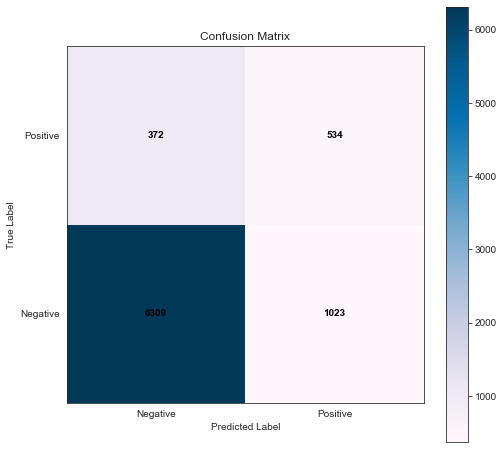

accuracy: 83.07 %
precision: 34.3 %
Recall: 58.94 %
specificity: 86.05 %
F-score: 43.36 %


In [109]:
metrics = confusion_mat_plot(true_flag, pred_flag)

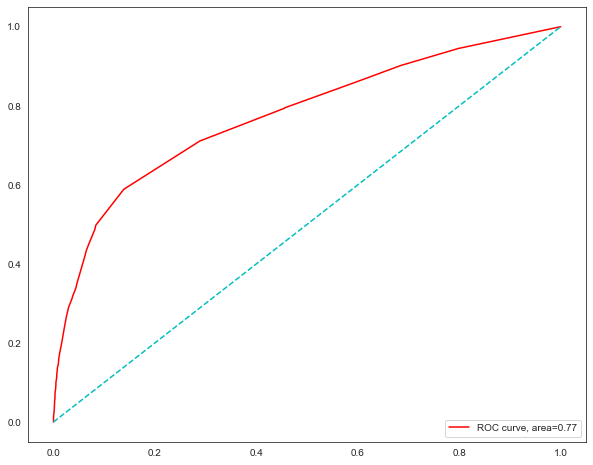

gini 54.976 %


In [110]:
gini = auc_plot(test_df_total[top_5_feat_2], true_flag, clf4)

# record new metrics
model_comparison['Without Eng Feat-Top 5'] = [gini, metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]]

We observe again a small sacrifice in performance, however, we have a less complicated model.

Let's check again the potential changes in feature importance (without engineered features).

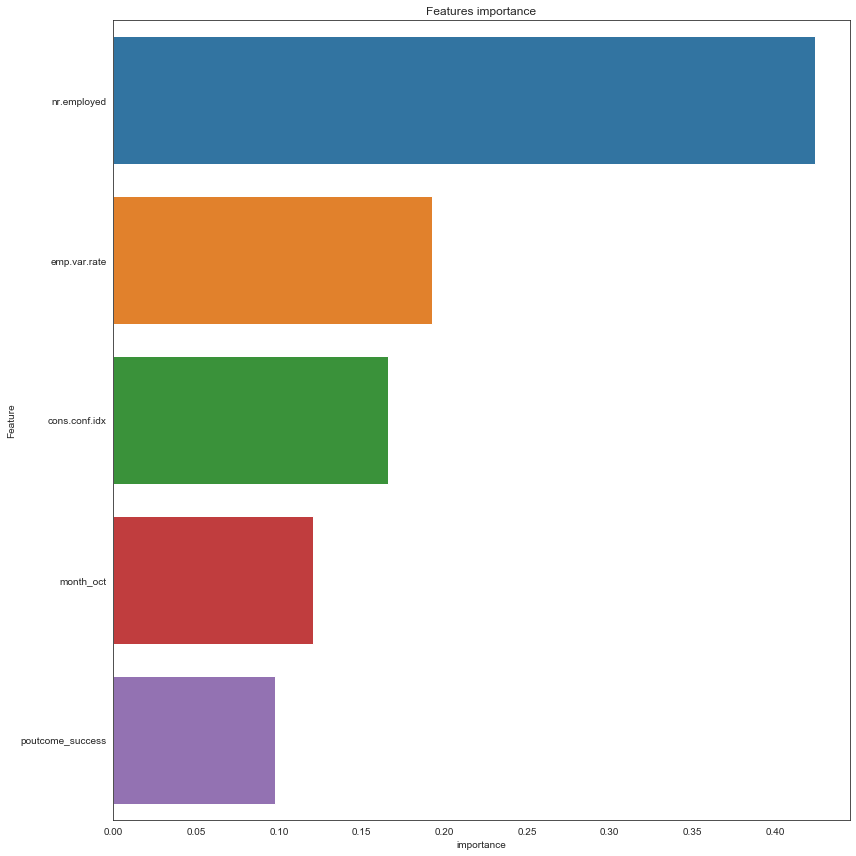

In [111]:
feature_importance_df4 = pd.DataFrame()
feature_importance_df4["Feature"] = top_5_feat_2
feature_importance_df4["importance"] = clf4.feature_importances_

# plot results
plt.figure(figsize=(12,12))
sns.barplot(x="importance", y="Feature", data=feature_importance_df4.sort_values(by="importance",ascending=False))
plt.title('Features importance')
plt.tight_layout()
plt.show()

# <a id='6'>Conclusion</a>

As we can see, the most predictive features that define the model's decision are the **rr.employed** and the result of the previous campaign, the feature **previous_success**.

There is a lot more analysis that can be done to find the best-tuned model for the topic. Other areas that we could touch to improve the model are:

* PCA analysis of the variables.
* We could apply Explainable AI libraries like SHAP and LIME and have a better understanding of what drives the decision on each occasion in a tree-based model, especially for the successfully subscribed customers.
* Due to the imbalanced nature of the dataset, we could actually apply techniques like SMOTE, to synthesize more balanced datasets that could potentially boost the training performance of our models.
* Eventually, if we are satisfied with the accuracy, we can try and apply some linear models that would be expected to be less performant, but more explainable like logistic regression.

Below we can see the cummulative results of all models:

### Gini Performance of All Models

In [112]:
%%time
# create all model arguments
X_test = [test_df_total[features], test_df_total[top_5_feat],
          test_df_total[train_df_total.columns[:-9]], test_df_total[top_5_feat_2]]
y_test = [true_flag, true_flag, true_flag, true_flag]
clf = [clf1, clf2, clf3, clf4]
model_names = model_comparison.columns.to_list()
model_weights = [None, None, None, None]

Wall time: 4 ms


Wall time: 0 ns


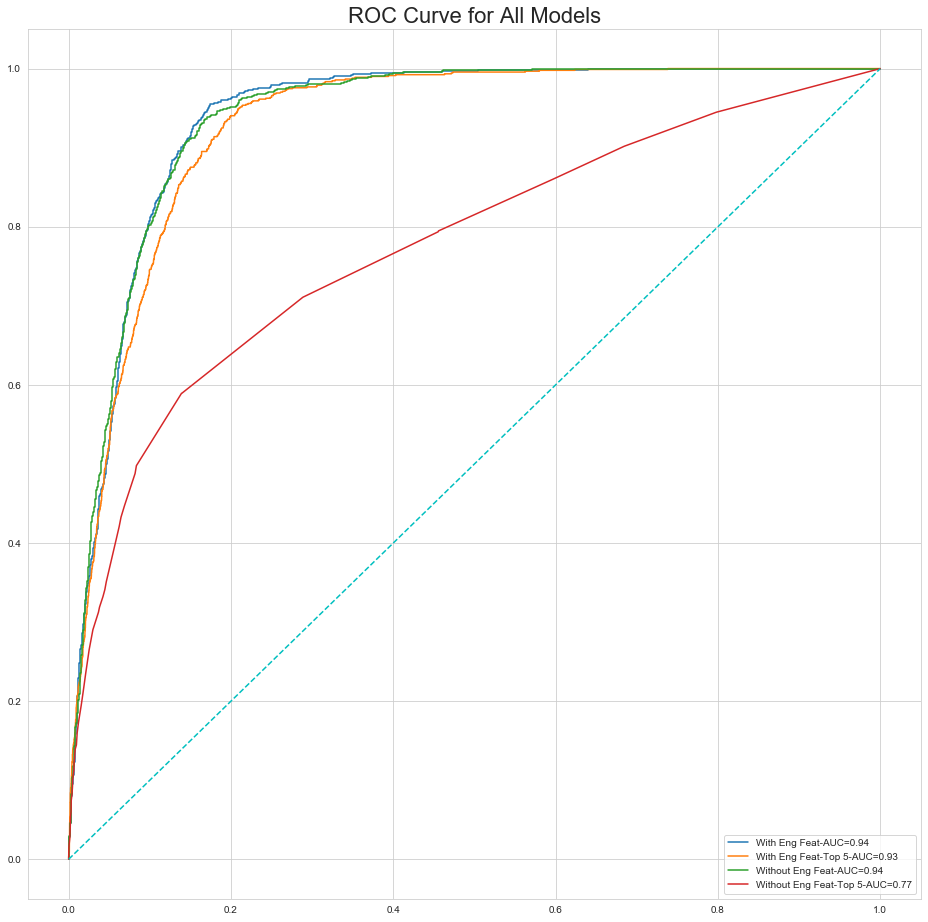

In [113]:
%time
auc_plot_all(X_test, y_test, clf, model_names, w=model_weights)

### Performance Metrics for All Models in 50% Cut-off point

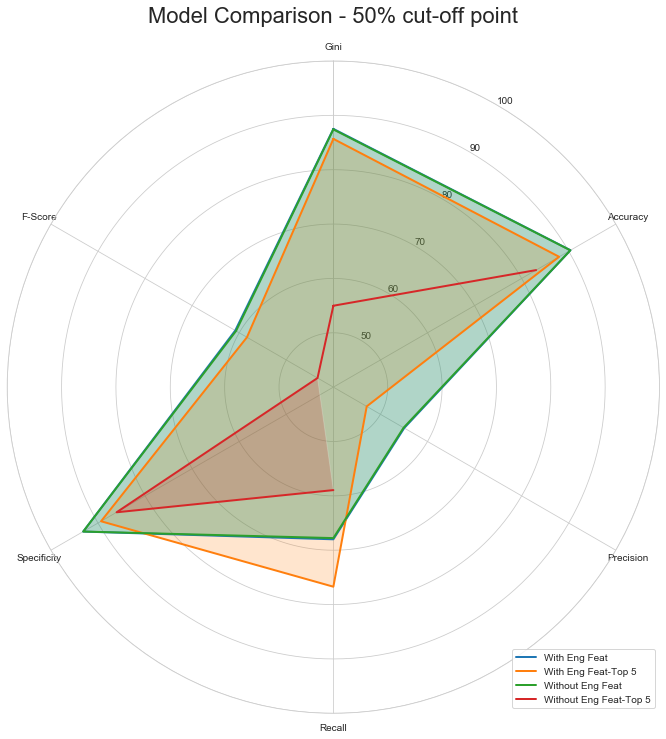

Wall time: 197 ms


In [114]:
%%time
plot_models_radar(model_comparison)

### Model Comparison on Different Cut-offs (interactive slider)

In [115]:
%%time
metrics_slider_plot(X_test, y_test, clf, model_names)

Wall time: 14.7 s
